In [1]:
import os
import re
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
from matplotlib import ticker
from scipy.stats import ttest_1samp
import statsmodels.stats.api as sms
import pickle
#%config Completer.use_jedi = False
#%matplotlib widget

In [2]:
"""
Define I/O paths
"""
# input directores
inDIR_data = '/mnt/c/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/data/'
inDIR_mods = '/mnt/c/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/models/'

# output directories
outDIR_tables = '/mnt/c/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/models/results_tables/'

# file name of gridded path intensity data (output from gps_to_gridded_path_intensity.ipynb)
griddata_f = 'full_grazing_time_gridded_all_for_model.csv'

# file name of model results
results_f = 'full_grazing_intensity_model_results.csv'

# file name of model coefficients
coefs_f = 'full_grazing_intensity_model_coefficients.csv'

In [3]:
"""
Define models for analyzing
"""
# create list of saved models
#mod_list = ['M0', 'M1', 'M2_bm', 'M2_top', 'M3_pc', 'M3_top', 'M4_top', 'M_best']
mod_list = ['M2_top', 'M3_top', 'M4_top', 'M_best']

# create dictionary to map top models to original models
top_mod_dict = {
    'M2_top': 'M2g',
    'M3_top': 'M3d',
    'M4_top': 'M4h',
    'M5_top': 'M5'
}

# create dictionaries of saved model results for AIC comparison
mod_aic_dict = {
    'TPC2': [top_mod_dict['M2_top'], 'M2_tpc'],
    'TPC3': [top_mod_dict['M3_top'], 'M3_tpc'],
    'TPC4': [top_mod_dict['M4_top'], top_mod_dict['M5_top']],
    'Hw1': ['M1', 'M5'],
    'Hw2': ['M2a', 'M2b', 'M2c', 'M2d', 'M2e', 'M2f', 'M2g'],
    'Hw3': ['M2a', 'M2b', 'M2c', 'M2d', 'M2e', 'M2f', 'M2g'],
    'Hw4a': ['M2a', 'M2b'],
    'Hw4b': ['M2f', 'M2g'],
    'Hw5': ['M2a', 'M2b', 'M2c', 'M2d', 'M2e', 'M2f', 'M2g'],
    'Hw6': ['M2a', 'M2b', 'M2c', 'M2d', 'M2e', 'M2f', 'M2g'],
    'Hw7': ['M3a', 'M3b', 'M3c', 'M3d'],
    'Hw8': ['M3a', 'M3b', 'M3c', 'M3d'],
    'Hw9': ['M3a', 'M3b', 'M3c', 'M3d'],
    'Ha1': ['M0', 'M1', 'M2', 'M3'],
    'Ha2': ['M0', 'M1', 'M2', 'M3', 'M4'],
    'Ha3': ['M0', 'M1', 'M2', 'M3', 'M4'],
    'Ha4': ['M0', 'M1', 'M2', 'M3', 'M4'],
}

# create dictionaries of saved scalers
scaler_dict = {}
for yr in [2016, 2017, 2018]:
    scaler_dict[yr] = {}
    for seas in ['early', 'mid', 'late']:
        scaler_dict[yr][seas] = {}
        for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
            with open(os.path.join(inDIR_mods, 'scaler_' + str(yr) + '_' + seas + '_' + c + '.pkl'), 'rb') as f:
                scaler_dict[yr][seas][c] = pickle.load(f)

In [64]:
"""
Define helper functions
"""
def abline(slope, intercept, color='black', linewidth=None):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', c=color, linewidth=linewidth)

def season_func(wk):
    if wk <= 26:
        return 'early'
    elif wk <= 32:
        return 'mid'
    elif wk >= 33:
        return 'late'

In [5]:
"""
Load data and models
"""
# read gridded data into dataframe
df_wkly_grid_full = pd.read_csv(os.path.join(inDIR_data, griddata_f), engine='python')

# read model results into dataframe
df_results = pd.read_csv(os.path.join(inDIR_mods, results_f), engine='python')

# read model results into dataframe
df_coefs = pd.read_csv(os.path.join(inDIR_mods, coefs_f), engine='python')

# create dictionary of the yearly models
yrly_mod_dict = {}
for yr in tqdm(df_coefs['Year'].unique()):
    yrly_mod_dict[yr] = {}
    for wk in df_coefs[df_coefs['Year'] == yr]['week'].unique():
        yrly_mod_dict[yr][wk] = {}
        for past in df_coefs[(df_coefs['Year'] == yr) &
                             (df_coefs['week'] == wk)]['Pasture'].unique():
            yrly_mod_dict[yr][wk][past] = {}
            for mod in mod_list:
                f_matched = [f for f in os.listdir(os.path.join(inDIR_mods, 'wkly')) if mod in f and '_' + str(wk) + '_' in f and str(yr) in f and past in f]
                if len(f_matched) == 1:
                    yrly_mod_dict[yr][wk][past][mod] = sm.load(os.path.join(
                        inDIR_mods, 'wkly', f_matched[0]))
                else:
                    print('ERROR: None and/or multiple matching files found:')
                    display(f_matched)

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
"""
Predict grazing intensity for chosen model
"""
# Change rare classes to 'Other' to match training data
df_wkly_grid_full['PC_dmt'].replace({'Bare_veg': 'Other', 'Bare': 'Other', 'UNK': 'Other', 'Shrub': 'Other'}, 
                               inplace=True)

# set the model for prediction
#mod_list = ['M_best']

min_class_n = 10


# predict relative probability of grazing across all data from seasonal models
for mod in mod_list:
    print('------ ' + mod + ' ------')
    for yr in tqdm(yrly_mod_dict):
        for wk in yrly_mod_dict[yr]:
            for past in yrly_mod_dict[yr][wk]:
                
                # get data from previous weeks for calculating grazing lag
                data_lag = df_wkly_grid_full[(df_wkly_grid_full['Year'] == yr) &
                                        (df_wkly_grid_full['Pasture'] == past) & 
                                        (df_wkly_grid_full['week'] >= wk - 6) &
                                        (df_wkly_grid_full['week'] < wk)]
                if len(data_lag) == 0:
                    print('Skipping ', yr, past, wk, ' due to lack of lagged data')
                    continue
                else:
                    # create average lagged grazing secs               
                    df_sub = df_wkly_grid_full.loc[(df_wkly_grid_full['Year'] == yr) &
                                                   (df_wkly_grid_full['week'] == wk) &
                                                   (df_wkly_grid_full['Pasture'] == past), :]
                    df_sub = df_sub.set_index(['UTM_X', 'UTM_Y', 'Pasture'])
                    df_sub['lag_avg'] = data_lag.groupby(['UTM_X', 'UTM_Y', 'Pasture'])['grazing_secs'].mean().reindex(df_sub.index)
                    df_sub = df_sub.reset_index()
                    df_sub.set_index('Unnamed: 0')
                
                    pc_drop_list = df_sub['PC_dmt'].value_counts().index[
                        df_sub['PC_dmt'].value_counts() < min_class_n]
                    tpc_drop_list = df_sub['TPC_c'].value_counts().index[
                        df_sub['TPC_c'].value_counts() < min_class_n]
                    
                    df_sub = df_sub[~df_sub['PC_dmt'].isin(pc_drop_list)]
                    df_sub = df_sub[~df_sub['TPC_c'].isin(tpc_drop_list)]
                    
                    df_wkly_grid_full.loc[(df_wkly_grid_full['Year'] == yr) &
                                          (df_wkly_grid_full['week'] == wk) &
                                          (df_wkly_grid_full['Pasture'] == past) &
                                          (~df_wkly_grid_full['PC_dmt'].isin(pc_drop_list)) &
                                          (~df_wkly_grid_full['TPC_c'].isin(tpc_drop_list)), 
                                          'pred_prop_' + mod] = yrly_mod_dict[yr][wk][past][mod].predict(df_sub).values

for mod in mod_list:                
    df_wkly_grid_full['pred_rel_freq_' + mod] = df_wkly_grid_full[
        'pred_prop_' + mod] * df_wkly_grid_full['grazing_wkly_sum'] / (df_wkly_grid_full['grazing_wkly_sum'] / 
                                                                       df_wkly_grid_full.groupby(
                                                                           ['Pasture', 
                                                                            'Year',
                                                                            'week',
                                                                            'Pasture',
                                                                            'mod_data'])['grazing_secs'].transform('count'))
                                                             

------ M2_top ------


  0%|          | 0/3 [00:00<?, ?it/s]

------ M3_top ------


  0%|          | 0/3 [00:00<?, ?it/s]

------ M4_top ------


  0%|          | 0/3 [00:00<?, ?it/s]

------ M_best ------


  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
test = df_wkly_grid_full.loc[(df_wkly_grid_full['Year'] == 2016) &
                      (df_wkly_grid_full['week'] == 20) &
                      (df_wkly_grid_full['Pasture'] == '26E'), :]
test[test['pred_prop_M4_top'].isnull()]['PC_dmt']#.sum()
#test['grazing_secs'].isnull().sum()
#test[test['PC_dmt'] == 'C3']
test.loc[253887]
test['TPC_c'].value_counts()

Flat Plains    799
Open Slopes    242
Lowlands       164
Highlands       87
Other            1
Name: TPC_c, dtype: int64

In [18]:
#df_wkly_grid_full['pred_rel_freq_M_best'].describe().round(2)
for mod in mod_list:
    df_wkly_grid_full.loc[df_wkly_grid_full['pred_rel_freq_' + mod] > 10.0, 
                          'pred_rel_freq_' + mod] = 10.0
    # * df_wkly_grid_full['grazing_wkly_sum'] / (df_wkly_grid_full['grazing_wkly_sum'] / 
                                                                             #df_wkly_grid_full.groupby(
                                                                              #  ['Pasture', 'mod_data'])['grazing_secs'].transform('count'))

In [19]:
#df_wkly_grid_full['pred_rel_freq_M_best'].describe().round(2)

In [20]:
"""
Bin seasonal predictions for categorical plotting and mapping
"""
rel_freq_bins = [0.0, 0.6, 0.8, 1.2, 1.4, 10.0]
bin_labs = ['Low', 'Mod. Low', 'Avg.', 'Mod. Hi', 'Hi']
df_wkly_grid_full['grazing_grp'] = pd.cut(df_wkly_grid_full['grazing_rel_freq'], 
                                          bins=rel_freq_bins, 
                                          labels=bin_labs,
                                          include_lowest=True)
for mod in mod_list:
    df_wkly_grid_full['pred_grp_' + mod] = pd.cut(df_wkly_grid_full['pred_rel_freq_' + mod],
                                                  bins=rel_freq_bins, 
                                                  labels=bin_labs,
                                                  include_lowest=True)

In [11]:
"""
Create and organize subsets of gridded data for plotting and analyses
"""
df_wkly_grid_full['season'] = pd.Categorical(df_wkly_grid_full['season_str'], ['early', 'mid', 'late'])
df_wkly_grid_train = df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'train']
df_wkly_grid_test = df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'test']


In [12]:
#df_wkly_grid_train[df_wkly_grid_train['pred_seas'] == 10]['pred_seas_grp'].value_counts()

In [13]:
df_wkly_grid_train_long = pd.wide_to_long(df_wkly_grid_train, stubnames='pred_grp', 
                i='Unnamed: 0',
                j='mod_pred_grp', sep='_', suffix='.*').reset_index()
df_wkly_grid_train_long['pred_grp'] = pd.Categorical(df_wkly_grid_train_long['pred_grp'], categories=['Low', 'Mod. Low', 'Avg.', 'Mod. Hi', 'Hi'])
df_wkly_grid_train_long['mod_pred_grp'].unique()

array(['M2_top', 'M3_top', 'M4_top', 'M_best'], dtype=object)

[Text(0, 0, 'Low'),
 Text(1, 0, 'Mod. Low'),
 Text(2, 0, 'Avg.'),
 Text(3, 0, 'Mod. Hi'),
 Text(4, 0, 'Hi')]

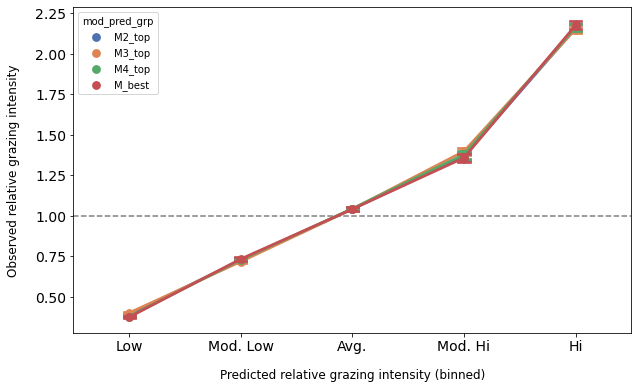

In [14]:
"""
Plot overall observed versus predicted relative grazing intensity for best model
"""
fig, ax = plt.subplots(figsize=(10, 6))
sns.pointplot(x='pred_grp', y='grazing_rel_freq', hue='mod_pred_grp', palette=sns.color_palette('deep'),
              data=df_wkly_grid_train_long, ax=ax, 
              errorbar=('ci', 95), n_boot=500, color='green', capsize=0.1, join=True)
#sns.pointplot(x='pred_grp_M3_top', y='grazing_rel_freq',
#              data=df_wkly_grid_train, ax=ax, 
#              ci=95, n_boot=500, color='orange', capsize=0.1, join=True)
#sns.pointplot(x='pred_grp_M4_top', y='grazing_rel_freq',
#              data=df_wkly_grid_train, ax=ax, 
#              ci=95, n_boot=500, color='purple', capsize=0.1, join=True)
#sns.pointplot(x='pred_grp_M_best', y='grazing_rel_freq',
#              data=df_wkly_grid_train, ax=ax, 
#              ci=95, n_boot=500, color='blue', capsize=0.1, join=True)
ax.axhline(y=1.0, linestyle='dashed', c='gray')
ax.set_xlabel('Predicted relative grazing intensity (binned)',  size=12.0, labelpad=15)
ax.set_ylabel('Observed relative grazing intensity', size=12.0, labelpad=15)
ax.tick_params(axis='y', labelsize=14.0)
ax.set_xticklabels(ax.get_xticklabels(), size=14.0)
#plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/Best_model_fit.png', 
#           bbox_inches='tight', dpi=300)

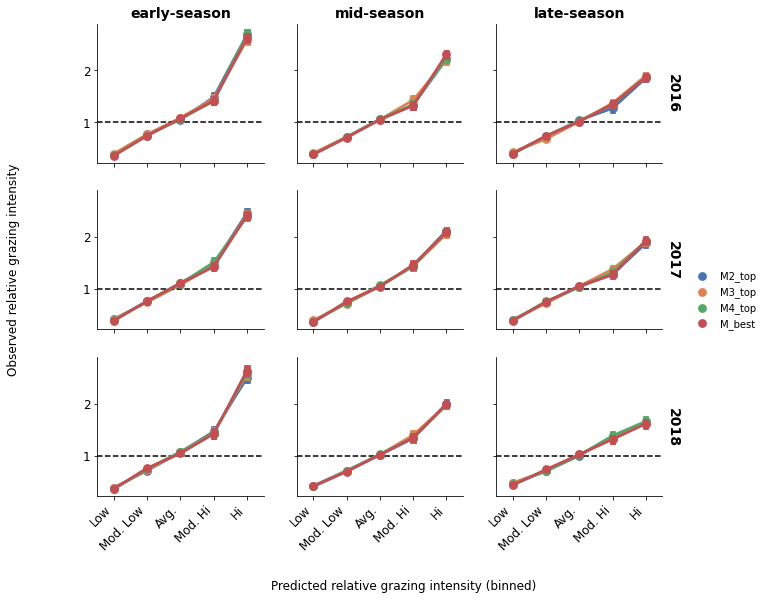

In [15]:
"""
Plot seasonal observed versus predicted relative grazing intensity for best model
"""
g = sns.catplot(data=df_wkly_grid_train_long, x='pred_grp', y='grazing_rel_freq', hue='mod_pred_grp', col='season', row='Year', kind='point',
                legend=False, sharey=True, height=2.5, aspect=1.2, margin_titles=True, palette=sns.color_palette('deep'),
                errorbar=('ci', 95), n_boot=500, color='black', capsize=0.1, join=True).add_legend()
g.set(xlabel='',
     ylabel='')
g.fig.supxlabel('Predicted relative grazing intensity (binned)', y=-0.1)
g.fig.supylabel('Observed relative grazing intensity', x=-0.05)
for ax in g.axes.flat:
    ax.axhline(y=1.0, linestyle='dashed', color='black')
    ax.tick_params(axis='y', labelsize=12.0)
    ax.set_xticklabels(ax.get_xticklabels(), size=12.0, rotation=45, horizontalalignment='right')
    plt.setp(ax.texts, text="") # remove the original texts


g.set_axis_labels()
g.set_titles(row_template = '{row_name}', 
             col_template = '{col_name}-season', 
             size=14.0,
             fontweight='bold')
plt.subplots_adjust(hspace=0.2, wspace=0.2)
#plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/Best_model_fit_X_season.png', 
#           bbox_inches='tight', dpi=300, pad_inches=0.25)

In [58]:
"""
Get DataFrame of coefficients for best models for each season
"""
coefs_dict = {}

for yr in tqdm(yrly_mod_dict):
    coefs_dict[yr] = {}
    for wk in yrly_mod_dict[yr]:
        coefs_dict[yr][wk] = {}
        for past in yrly_mod_dict[yr][wk]:
            coefs_dict[yr][wk][past] = {}
            for mod in yrly_mod_dict[yr][wk][past]:
                coefs_dict[yr][wk][past][mod] = pd.read_html((yrly_mod_dict[yr][wk][past][mod].summary().tables[1]).as_html(), 
                                                         header=0, index_col=0)[0]

  0%|          | 0/3 [00:00<?, ?it/s]

In [59]:
"""
Reformat and save coefficients for final model for table
"""
for yr in tqdm(coefs_dict):
    for wk in coefs_dict[yr]:
        for past in coefs_dict[yr][wk]:
            for mod in coefs_dict[yr][wk][past]:
                coefs_dict[yr][wk][past][mod] = coefs_dict[yr][wk][past][mod].rename_axis('Param').reset_index()
                coefs_dict[yr][wk][past][mod]['Param'] = coefs_dict[yr][wk][past][mod]['Param'].apply(
                    lambda x: re.sub('\]', 
                                     '',
                                     re.sub('C\(PC_dmt, Treatment\(reference\="C3_C4_mix"\)\)\[T\.', 
                                            '', 
                                            str(x))))
                coefs_dict[yr][wk][past][mod]['Param'] = coefs_dict[yr][wk][past][mod]['Param'].apply(
                    lambda x: re.sub('\]', 
                                     '',
                                     re.sub('C\(TPC_c, Treatment\(reference\="Flat Plains"\)\)\[T\.', 
                                            'TPC:', 
                                            str(x))))
                coefs_dict[yr][wk][past][mod]['Param'] = coefs_dict[yr][wk][past][mod]['Param'].apply(
                    lambda x: re.sub('TPC:', '', re.sub('TPC:Other', 'Complex', x)))
        
idx = 0
for yr in coefs_dict:
    for wk in coefs_dict[yr]:
        for past in coefs_dict[yr][wk]:
            if idx == 0:
                df_coefs_wk = coefs_dict[yr][wk][past]['M_best']
                df_coefs_wk['week'] = wk
                df_coefs_wk['Year'] = yr
                df_coefs_wk['Pasture'] = past
            else:
                df_tmp = coefs_dict[yr][wk][past]['M_best']
                df_tmp['week'] = wk
                df_tmp['Year'] = yr
                df_tmp['Pasture'] = past
                df_coefs_wk = df_coefs_wk.append(df_tmp)
            idx += 1
    #        coefs_dict[yr][wk]['M_best'].to_csv(os.path.join(outDIR_tables, 'M_best_coefs_' + str(yr) + '_' + wk + '.csv'))

  0%|          | 0/3 [00:00<?, ?it/s]

In [61]:
df_coefs_wk['Model'] = 'M_best'
df_coefs_wk['coef_ci_lwr'] = df_coefs_wk['[0.025']
df_coefs_wk['coef_ci_upr'] = df_coefs_wk['0.975]']
df_coefs_wk['Param'] = df_coefs_wk['Param'].apply(
                lambda x: re.sub('\]', 
                                 '',
                                 re.sub('C\(PC_dmt, Treatment\(reference\="C3_C4_mix"\)\)\[T\.', 
                                        '', 
                                        str(x))))

df_coefs_wk['Param'] = df_coefs_wk['Param'].apply(
                lambda x: re.sub('\]', 
                                 '',
                                 re.sub('C\(TPC_c, Treatment\(reference\="Flat Plains"\)\)\[T\.', 
                                        'TPC:', 
                                        str(x))))

df_coefs_wk['Param'] = df_coefs_wk['Param'].apply(
                lambda x: re.sub('TPC:', '', re.sub('TPC:Other', 'Complex', x)))

In [65]:
df_coefs_wk['season'] = df_coefs_wk['week'].apply(lambda x: season_func(x))
df_coefs_wk['season'] = pd.Categorical(df_coefs_wk['season'], ['early', 'mid', 'late'])

In [70]:
df_coefs_wk

,Param,coef,std err,z,P>|z|,[0.025,0.975],week,Year,Pasture,Model,coef_ci_lwr,coef_ci_upr,season
0,Intercept,-8.3676,0.151,-55.388,0.000,-8.664,-8.071,21,2016.0,17N,M_best,-8.664,-8.071,early
1,C3,0.2261,0.403,0.561,0.574,-0.563,1.015,21,2016.0,17N,M_best,-0.563,1.015,early
2,C4,-0.8025,0.166,-4.838,0.000,-1.128,-0.477,21,2016.0,17N,M_best,-1.128,-0.477,early
3,Other,0.1219,0.533,0.229,0.819,-0.924,1.168,21,2016.0,17N,M_best,-0.924,1.168,early
4,Saltgrass,-0.0536,0.151,-0.354,0.723,-0.350,0.243,21,2016.0,17N,M_best,-0.350,0.243,early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Intercept,-8.0924,0.140,-57.988,0.000,-8.366,-7.819,32,2018.0,7NW,M_best,-8.366,-7.819,mid
1,lag_avg,0.0025,0.001,4.518,0.000,0.001,0.004,32,2018.0,7NW,M_best,0.001,0.004,mid
2,dFence,0.1045,0.074,1.412,0.158,-0.041,0.249,32,2018.0,7NW,M_best,-0.041,0.249,mid
3,dTank,-0.6310,0.151,-4.191,0.000,-0.926,-0.336,32,2018.0,7NW,M_best,-0.926,-0.336,mid


In [84]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

df_coefs_seas = df_coefs_wk.groupby(['Year', 'season', 'Model', 'Param']).agg({'coef': [('coef', lambda x: mean_confidence_interval(x)[0]),
                                                                                   ('coef_ci_lwr', lambda x: mean_confidence_interval(x)[1]),
                                                                                   ('coef_ci_upr', lambda x: mean_confidence_interval(x)[2])]})
df_coefs_seas.columns = df_coefs_seas.columns.droplevel(0)
df_coefs_seas = df_coefs_seas.dropna(axis=0, how='all')

/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [88]:
df_coefs_seas['significant'] = df_coefs_seas.apply(lambda v: 'Yes' if np.sign(v['coef_ci_lwr']) == np.sign(v['coef_ci_upr']) else 'No', axis=1)
df_coefs_seas = df_coefs_seas.sort_values(['Year', 'season']).reset_index()
df_coefs_seas

,Year,season,Model,Param,coef,coef_ci_lwr,coef_ci_upr,significant
0,2016.0,early,M_best,Biomass,-0.206005,-0.411384,-0.000626,Yes
1,2016.0,early,M_best,Biomass:CP,0.071745,-0.243379,0.386870,No
2,2016.0,early,M_best,C3,-0.672360,-2.190574,0.845854,No
3,2016.0,early,M_best,C3:Biomass,0.345000,NaN,NaN,No
4,2016.0,early,M_best,C3:I(Biomass ** 2),-0.131300,NaN,NaN,No
...,...,...,...,...,...,...,...,...
296,2018.0,late,M_best,Saltgrass:PC_div,0.117700,NaN,NaN,No
297,2018.0,late,M_best,alpha,8.898005,7.639494,10.156515,Yes
298,2018.0,late,M_best,dFence,0.056459,-0.029439,0.142357,No
299,2018.0,late,M_best,dTank,0.033032,-0.068307,0.134370,No


In [91]:
 
"""df_coefs_wkly = df_coefs.drop(columns='Unnamed: 0').groupby(['Year', 
                                             'Season',
                                             'Model', 
                                             'week', 
                                             'Pasture', 
                                             'Param']).mean().reset_index()
df_coefs_past = df_coefs_wkly.groupby(['Year',
                                       'Season',
                                       'Model',
                                       'Pasture',
                                       'Param']).mean().reset_index().drop(columns='week')"""
"""
df_coefs_seas = df_coefs.drop(columns='Unnamed: 0').groupby(['Year',                                             
                       'season_str',
                       'Model',
                       'Param']).mean().reset_index()#.drop(columns='week')
df_coefs_seas['coef_ci_lwr'] = df_coefs.drop(columns='Unnamed: 0').groupby(['Year',                                             
                       'season_str',
                       'Model',
                       'Param'])['coef'].apply(lambda x: np.mean(x) - 1.97*(np.std(x)/np.sqrt(len(x)))).values
df_coefs_seas['coef_ci_upr'] = df_coefs.drop(columns='Unnamed: 0').groupby(['Year',                                             
                       'season_str',
                       'Model',
                       'Param'])['coef'].apply(lambda x: np.mean(x) + 1.97*(np.std(x)/np.sqrt(len(x)))).values
df_coefs_seas['Param'] = df_coefs_seas['Param'].apply(
                lambda x: re.sub('\]', 
                                 '',
                                 re.sub('C\(PC_dmt, Treatment\(reference\="C3_C4_mix"\)\)\[T\.', 
                                        '', 
                                        str(x))))

df_coefs_seas['Param'] = df_coefs_seas['Param'].apply(
                lambda x: re.sub('\]', 
                                 '',
                                 re.sub('C\(TPC_c, Treatment\(reference\="Flat Plains"\)\)\[T\.', 
                                        'TPC:', 
                                        str(x))))

df_coefs_seas['Param'] = df_coefs_seas['Param'].apply(
                lambda x: re.sub('TPC:', '', re.sub('TPC:Other', 'Complex', x)))

df_coefs_seas['significant'] = df_coefs_seas.apply(lambda v: 'Yes' if np.sign(v['coef_ci_lwr']) == np.sign(v['coef_ci_upr']) else 'No', axis=1)

df_coefs_seas['season'] = pd.Categorical(df_coefs_seas['season_str'], ['early', 'mid', 'late'])
"""
for yr in df_coefs_seas['Year'].unique():
    for seas in df_coefs_seas['season'].unique():
        df_coefs_seas[(df_coefs_seas['Year'] == yr) &
                              (df_coefs_seas['season'] == seas) &
                              (df_coefs_seas['Model'] == 'M_best')].to_csv(os.path.join(outDIR_tables, 'M_best_coefs_' + str(yr) + '_' + seas + '.csv'))

In [92]:
"""
Display best model coefficients for chosen season. Significant if red
"""

def style_sig(v, props=''):
    return np.repeat(props, len(v)) if v['significant'] == 'Yes' else None

for yr in tqdm(df_coefs_seas['Year'].unique()):
    for seas in df_coefs_seas[df_coefs_seas['Year'] == yr]['season'].unique():
        print('\n---------------------- ' + str(yr) + ': ' + seas + ' --------------------')
        display(df_coefs_seas[(df_coefs_seas['Year'] == yr) &
                              (df_coefs_seas['season'] == seas) &
                              (df_coefs_seas['Model'] == 'M_best')].style.apply(style_sig, 
                                                                                props='color:red;',
                                                                                axis=1))


  0%|          | 0/3 [00:00<?, ?it/s]


---------------------- 2016.0: early --------------------


,Year,season,Model,Param,coef,coef_ci_lwr,coef_ci_upr,significant
0,2016.000000,early,M_best,Biomass,-0.206005,-0.411384,-0.000626,Yes
1,2016.000000,early,M_best,Biomass:CP,0.071745,-0.243379,0.386870,No
2,2016.000000,early,M_best,C3,-0.672360,-2.190574,0.845854,No
3,2016.000000,early,M_best,C3:Biomass,0.345000,nan,nan,No
4,2016.000000,early,M_best,C3:I(Biomass ** 2),-0.131300,nan,nan,No
5,2016.000000,early,M_best,C3:PC_div,0.940000,-2.173285,4.053285,No
6,2016.000000,early,M_best,C4,0.030755,-0.165944,0.227453,No
7,2016.000000,early,M_best,C4:Biomass,0.539900,nan,nan,No
8,2016.000000,early,M_best,C4:CP,-0.571050,-1.730127,0.588027,No
9,2016.000000,early,M_best,C4:I(Biomass ** 2),-0.343400,nan,nan,No



---------------------- 2016.0: mid --------------------


ValueError: Function <function style_sig at 0x7f9f4944d310> returned the wrong shape.
Result has shape: (30,)
Expected shape:   (30, 8)


---------------------- 2016.0: late --------------------


ValueError: Function <function style_sig at 0x7f9f4944d310> returned the wrong shape.
Result has shape: (37,)
Expected shape:   (37, 8)


---------------------- 2017.0: early --------------------


,Year,season,Model,Param,coef,coef_ci_lwr,coef_ci_upr,significant
104,2017.000000,early,M_best,Biomass,-0.467355,-0.629276,-0.305433,Yes
105,2017.000000,early,M_best,Biomass:CP,0.104580,-0.558495,0.767655,No
106,2017.000000,early,M_best,C3,-0.475133,-1.916804,0.966537,No
107,2017.000000,early,M_best,C3:Biomass,-4.897300,nan,nan,No
108,2017.000000,early,M_best,C3:I(Biomass ** 2),2.657300,nan,nan,No
109,2017.000000,early,M_best,C3:PC_div,0.173767,-1.542223,1.889756,No
110,2017.000000,early,M_best,C4,0.089583,-0.203303,0.382469,No
111,2017.000000,early,M_best,C4:Biomass,-0.678060,-1.644808,0.288688,No
112,2017.000000,early,M_best,C4:I(Biomass ** 2),0.053640,-1.281911,1.389191,No
113,2017.000000,early,M_best,C4:PC_div,0.141767,-0.566575,0.850108,No



---------------------- 2017.0: mid --------------------


,Year,season,Model,Param,coef,coef_ci_lwr,coef_ci_upr,significant
136,2017.000000,mid,M_best,Biomass,-0.635030,-1.135730,-0.134331,Yes
137,2017.000000,mid,M_best,Biomass:CP,0.770567,-0.034631,1.575764,No
138,2017.000000,mid,M_best,C3,0.409275,-0.863407,1.681957,No
139,2017.000000,mid,M_best,C3:Biomass,-1.218767,-5.826863,3.389330,No
140,2017.000000,mid,M_best,C3:I(Biomass ** 2),-2.592000,-13.170266,7.986266,No
141,2017.000000,mid,M_best,C3:PC_div,-1.275450,-17.941543,15.390643,No
142,2017.000000,mid,M_best,C4,0.238323,-0.231901,0.708547,No
143,2017.000000,mid,M_best,C4:Biomass,-1.155525,-2.794663,0.483613,No
144,2017.000000,mid,M_best,C4:CP,0.593050,-8.291764,9.477864,No
145,2017.000000,mid,M_best,C4:I(Biomass ** 2),-0.212250,-0.738674,0.314174,No



---------------------- 2017.0: late --------------------


,Year,season,Model,Param,coef,coef_ci_lwr,coef_ci_upr,significant
172,2017.000000,late,M_best,Biomass,-0.631187,-1.252770,-0.009605,Yes
173,2017.000000,late,M_best,Biomass:CP,0.711233,-1.990693,3.413160,No
174,2017.000000,late,M_best,C3,0.100550,-0.541268,0.742368,No
175,2017.000000,late,M_best,C3:Biomass,1.195300,nan,nan,No
176,2017.000000,late,M_best,C3:I(Biomass ** 2),-1.548200,nan,nan,No
177,2017.000000,late,M_best,C3:PC_div,0.150867,-1.196595,1.498328,No
178,2017.000000,late,M_best,C4,-0.092736,-0.410250,0.224777,No
179,2017.000000,late,M_best,C4:Biomass,-0.339850,-1.899537,1.219837,No
180,2017.000000,late,M_best,C4:I(Biomass ** 2),-0.196550,-24.415212,24.022112,No
181,2017.000000,late,M_best,C4:PC_div,0.012300,-0.520690,0.545290,No



---------------------- 2018.0: early --------------------


ValueError: Function <function style_sig at 0x7f9f4944d310> returned the wrong shape.
Result has shape: (33,)
Expected shape:   (33, 8)


---------------------- 2018.0: mid --------------------


,Year,season,Model,Param,coef,coef_ci_lwr,coef_ci_upr,significant
236,2018.000000,mid,M_best,Biomass,-1.441571,-2.629626,-0.253516,Yes
237,2018.000000,mid,M_best,Biomass:CP,-0.396220,-3.068551,2.276111,No
238,2018.000000,mid,M_best,C3,0.860112,-0.478382,2.198607,No
239,2018.000000,mid,M_best,C3:Biomass,10.499400,nan,nan,No
240,2018.000000,mid,M_best,C3:I(Biomass ** 2),-10.318500,nan,nan,No
241,2018.000000,mid,M_best,C3:PC_div,-1.870767,-6.895540,3.154006,No
242,2018.000000,mid,M_best,C4,0.334990,-0.022441,0.692421,No
243,2018.000000,mid,M_best,C4:Biomass,-0.770000,nan,nan,No
244,2018.000000,mid,M_best,C4:I(Biomass ** 2),0.577700,nan,nan,No
245,2018.000000,mid,M_best,C4:PC_div,-0.734200,-0.972674,-0.495726,Yes



---------------------- 2018.0: late --------------------


ValueError: Function <function style_sig at 0x7f9f4944d310> returned the wrong shape.
Result has shape: (34,)
Expected shape:   (34, 8)

Text(0, 0.5, 'Biomass (kg/ha)')

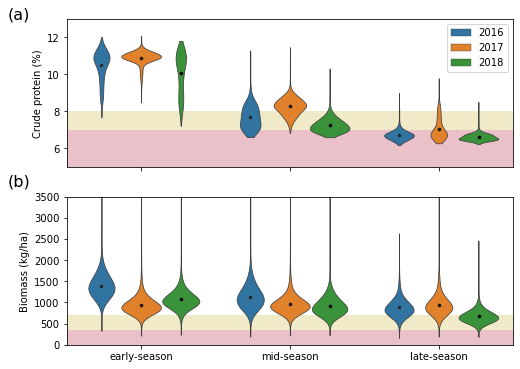

In [101]:
"""
FIGURE: Varibility in crude protein (a) and biomass (b) by sub-season and year
"""
fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)
p1 = sns.violinplot(x='season', y='CP_orig', hue='Year', bw=0.5, cut=0, linewidth=0.75, inner=None,
            data=df_wkly_grid_train, ax=axs[0], zorder=10)
#axs[0].fill_between(range(-1, 4), 8, 13, color='#117733', alpha=0.2, edgecolor=None, zorder=0)
p1.fill_between(np.arange(-0.5, 3), 7, 8, color='#DDCC77', alpha=0.4, edgecolor=None, zorder=0)
p1.fill_between(np.arange(-0.5, 3), 0, 7, color='#CC6677', alpha=0.4, edgecolor=None, zorder=0)
p1.set_ylim((5,13))
p1.set_xmargin(0.0)
p1.text(x=-0.9, y=13.0, s='(a)', fontsize=16.0)
h, l = p1.get_legend_handles_labels()
#leg.update_from(p1)
p1_mean = sns.pointplot(x='season', y='CP_orig',  hue='Year', errorbar=None,
          join=False, dodge=0.535, scale=0.4, color='black',
          data=df_wkly_grid_train, ax=axs[0])
p1_mean.legend().remove()
axs[0].set_xlabel(None)
p1.set_ylabel('Crude protein (%)')
p1.legend(h, l)

p2 = sns.violinplot(x='season', y='Biomass_orig', hue='Year', bw=0.5, cut=0, linewidth=0.75, inner=None,
            data=df_wkly_grid_train, ax=axs[1])
#axs[1].fill_between(range(-1, 4), 700, 3500, color='#117733', alpha=0.2, edgecolor=None, zorder=0)
p2.fill_between(np.arange(-0.5, 3), 350, 700, color='#DDCC77', alpha=0.4, edgecolor=None, zorder=0)
p2.fill_between(np.arange(-0.5, 3), 0, 350, color='#CC6677', alpha=0.4, edgecolor=None, zorder=0)
p2.set_ylim((0, 3500))
p2.legend().remove()
p2.set_xmargin(0.0)
p2.text(x=-0.9, y=3750, s='(b)', fontsize=16.0)
p2_mean = sns.pointplot(x='season', y='Biomass_orig',  hue='Year', errorbar=None,
          join=False, dodge=0.535, scale=0.4, color='black',
          data=df_wkly_grid_train, ax=axs[1])
p2_mean.legend().remove()
p2.set_xticklabels([x.get_text() + '-season' for x in p2.get_xticklabels()])
axs[1].set_xlabel(None)
p2.set_ylabel('Biomass (kg/ha)')

#plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/violinplots_CP_BM_X_Year_X_Season.png', 
#            bbox_inches='tight', dpi=300)

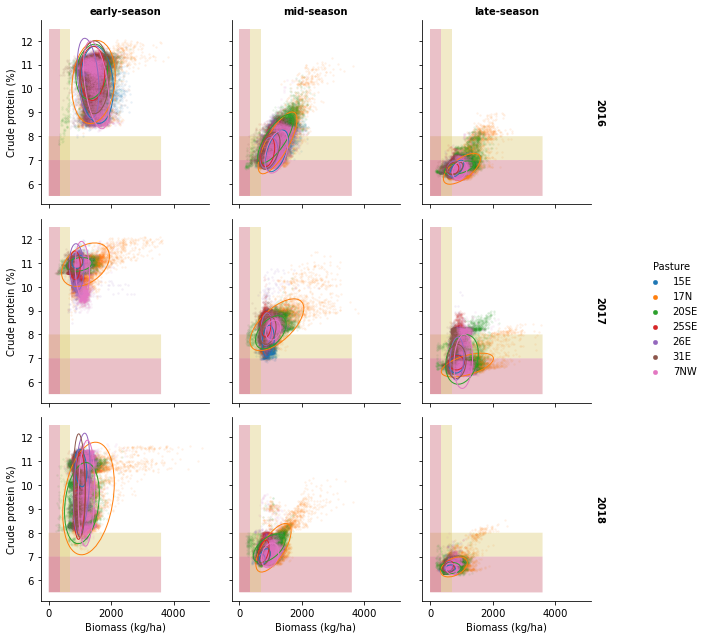

In [102]:
"""
FIGURE: Covariance in crude protein and biomass by year, sub-season and pasture
"""
def get_cov_ellipse(cov, centre, nstd, **kwargs):
    from matplotlib.patches import Ellipse
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)

def draw_cov_ellipse(*args, **kwargs):
    data = kwargs.pop('data')
    c = kwargs.pop('color')
    x = kwargs.pop('x')
    y = kwargs.pop('y')
    cov = np.cov(data.dropna(axis=0)[x], data.dropna(axis=0)[y])
    e = get_cov_ellipse(cov, (data.dropna(axis=0)[x].mean(), 
                              data.dropna(axis=0)[y].mean()), 2, fc='none', ec=c, alpha=1.0)
    ax = plt.gca()
    ax.scatter(data.dropna(axis=0)[x], data.dropna(axis=0)[y], s=0.0, alpha=0.3)
    ax.add_artist(e)

g = sns.FacetGrid(data=df_wkly_grid_train,#[df_wkly_grid_train['Pasture'].isin(['17N', '20SE'])],#[df_wkly_grid_train['week'].isin([23, 29, 36])], 
                 col='season', row='Year', hue='Pasture', legend_out=True, margin_titles=True)
g.map_dataframe(sns.scatterplot, x='Biomass_orig', y='CP_orig', edgecolor=None, alpha=0.1, s=4.0).add_legend()
g.map_dataframe(draw_cov_ellipse, x='Biomass_orig', y='CP_orig')#.add_legend()
g.set_xlabels('Biomass (kg/ha)')
g.set_ylabels('Crude protein (%)')

leg = g.legend
for hand in leg.legendHandles:
    hand._sizes = [22.0]
    hand.set_alpha(1.0)

for ax in g.axes.flat:
    ax.fill_between(np.arange(0, 3600), 7, 8,
                       color='#DDCC77', alpha=0.4, edgecolor=None, zorder=0)
    ax.fill_between(np.arange(0, 3600), 5.5, 7,
                       color='#CC6677', alpha=0.4, edgecolor=None, zorder=0)
    ax.fill_between(range(350, 700), 5.5, 12.5, 
                    color='#DDCC77', alpha=0.4, edgecolor=None, zorder=0)
    ax.fill_between(range(0, 350), 5.5, 12.5, 
                    color='#CC6677', alpha=0.4, edgecolor=None, zorder=0)
    plt.setp(ax.texts, text="") # remove the original texts

g.set_titles(row_template = '{row_name}', col_template = '{col_name}-season', fontweight='bold')
#plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/covariance_CP_BM_X_Year_X_Season_X_Pasture.png', 
#            bbox_inches='tight', dpi=300)

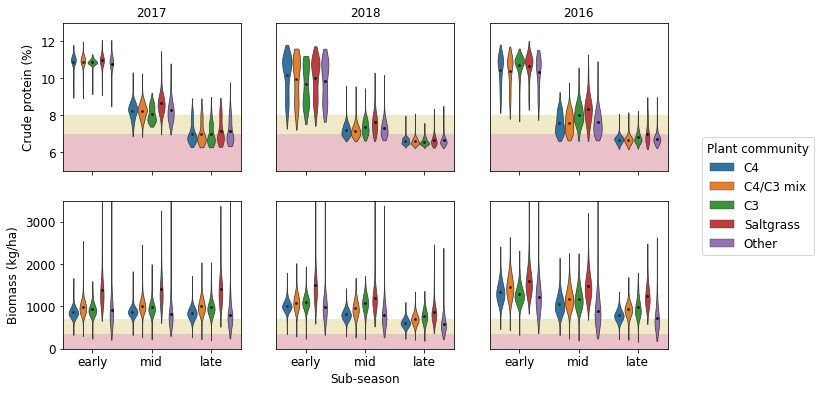

In [103]:
"""
FIGURE: Varibility in crude protein (a) and biomass (b) by sub-season across plant communities
"""
fig, axs = plt.subplots(nrows=2, ncols=len(df_wkly_grid_train['Year'].unique()),
                        figsize=(12, 6), sharex=True, gridspec_kw={'right': 0.825})
for idx, yr in enumerate(df_wkly_grid_train['Year'].unique()):
    p1 = sns.violinplot(x='season', y='CP_orig', hue='PC_dmt',  bw=0.5, cut=0, inner=None, linewidth=0.75,
                data=df_wkly_grid_train[df_wkly_grid_train['Year'] == yr], ax=axs[0, idx],
                       hue_order=['C4', 'C3_C4_mix', 'C3', 'Saltgrass', 'Other'])
    
    axs[0, idx].fill_between(np.arange(-0.5, 3), 7, 8, color='#DDCC77', alpha=0.4, edgecolor=None, zorder=0)
    axs[0, idx].fill_between(np.arange(-0.5, 3), 0, 7, color='#CC6677', alpha=0.4, edgecolor=None, zorder=0)
    handles, labels = axs[0,idx].get_legend_handles_labels()
    labels = ['C4/C3 mix' if x == 'C3_C4_mix' else x for x in labels] 
    p1.legend().remove()
    p1.set_ylim((5,13))
    p1.set_xmargin(0.0)
    p1.set_title(yr, size=12.0)
    p1_mean = sns.pointplot(x='season', y='CP_orig',  hue='PC_dmt', errorbar=None,
                  hue_order=['C4', 'C3_C4_mix', 'C3', 'Saltgrass', 'Other'], join=False, dodge=0.65, scale=0.3, color='black',
                  data=df_wkly_grid_train[df_wkly_grid_train['Year'] == yr], ax=axs[0, idx])
    p1_mean.legend().remove()
    axs[0,idx].set_ylabel('Crude protein (%)', size=12, labelpad=5)
    axs[0,idx].set_xlabel(None)

    p2 = sns.violinplot(x='season', y='Biomass_orig', hue='PC_dmt',  bw=0.5, cut=0, inner=None, linewidth=0.75,
                data=df_wkly_grid_train[df_wkly_grid_train['Year'] == yr], ax=axs[1, idx],
                       hue_order=['C4', 'C3_C4_mix', 'C3', 'Saltgrass', 'Other'])
    axs[1,idx].fill_between(np.arange(-0.5, 3), 350, 700, color='#DDCC77', alpha=0.4, edgecolor=None, zorder=0)
    axs[1,idx].fill_between(np.arange(-0.5, 3), 0, 350, color='#CC6677', alpha=0.4, edgecolor=None, zorder=0)
    p2.legend().remove()
    p2.set_ylim((0, 3500))
    p2.set_xmargin(0.0)
    p2_mean = sns.pointplot(x='season', y='Biomass_orig',  hue='PC_dmt', errorbar=None,
              hue_order=['C4', 'C3_C4_mix', 'C3', 'Saltgrass', 'Other'], join=False, dodge=0.65, scale=0.3, color='black',
              data=df_wkly_grid_train[df_wkly_grid_train['Year'] == yr], ax=axs[1, idx])
    p2_mean.legend().remove()
    axs[1,idx].set_ylabel('Biomass (kg/ha)', size=12, labelpad=5)
    axs[1,idx].set_xlabel(None)

for idx, ax in enumerate(axs.flatten()):
    ax.set_xticklabels(ax.get_xticklabels(), size=12.0)
    ax.set_xticklabels(ax.get_xticklabels(), size=12.0)
    ax.tick_params(axis='y', labelsize=12.0)
    if (idx == 0) | (idx == len(axs.flatten())/axs.shape[0]):
        continue
    else:
        ax.axes.yaxis.set_ticks([])
        ax.set_ylabel('')
    if idx == 4:
        ax.set_xlabel('Sub-season', size=12.0)

fig.legend(handles, labels, loc='center right', 
           title='Plant community', fontsize=12.0, title_fontsize=12.0)
#plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/violinplots_CP_BM_X_Season_X_PCdmt.png', 
#            bbox_inches='tight', dpi=300)

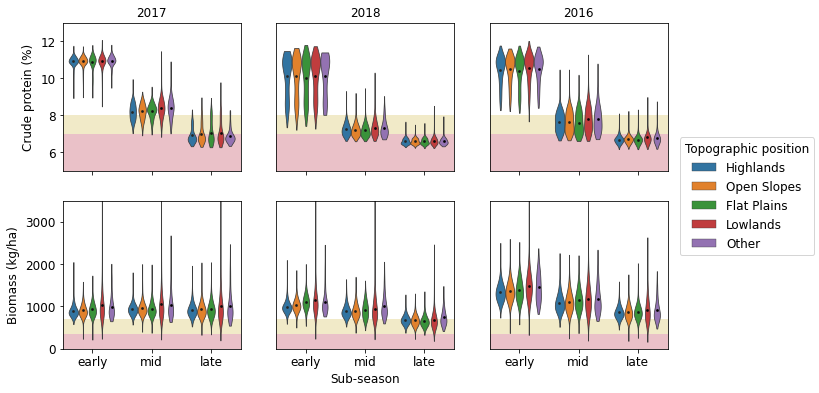

In [104]:
"""
FIGURE: Varibility in crude protein (a) and biomass (b) by sub-season across plant communities
"""
fig, axs = plt.subplots(nrows=2, ncols=len(df_wkly_grid_train['Year'].unique()),
                        figsize=(12, 6), sharex=True, gridspec_kw={'right': 0.825})
for idx, yr in enumerate(df_wkly_grid_train['Year'].unique()):
    p1 = sns.violinplot(x='season', y='CP_orig', hue='TPC_c',  bw=0.5, cut=0, inner=None, linewidth=0.75,
                data=df_wkly_grid_train[df_wkly_grid_train['Year'] == yr], ax=axs[0, idx],
                       hue_order=['Highlands', 'Open Slopes', 'Flat Plains', 'Lowlands', 'Other'])
    
    axs[0, idx].fill_between(np.arange(-0.5, 3), 7, 8, color='#DDCC77', alpha=0.4, edgecolor=None, zorder=0)
    axs[0, idx].fill_between(np.arange(-0.5, 3), 0, 7, color='#CC6677', alpha=0.4, edgecolor=None, zorder=0)
    handles, labels = axs[0,idx].get_legend_handles_labels()
    p1.legend().remove()
    p1.set_ylim((5,13))
    p1.set_xmargin(0.0)
    p1.set_title(yr, size=12.0)
    p1_mean = sns.pointplot(x='season', y='CP_orig',  hue='TPC_c', errorbar=None,
                  hue_order=['Highlands', 'Open Slopes', 'Flat Plains', 'Lowlands', 'Other'], join=False, dodge=0.65, scale=0.3, color='black',
                  data=df_wkly_grid_train[df_wkly_grid_train['Year'] == yr], ax=axs[0, idx])
    p1_mean.legend().remove()
    axs[0,idx].set_ylabel('Crude protein (%)', size=12, labelpad=5)
    axs[0,idx].set_xlabel(None)

    p2 = sns.violinplot(x='season', y='Biomass_orig', hue='TPC_c',  bw=0.5, cut=0, inner=None, linewidth=0.75,
                data=df_wkly_grid_train[df_wkly_grid_train['Year'] == yr], ax=axs[1, idx],
                       hue_order=['Highlands', 'Open Slopes', 'Flat Plains', 'Lowlands', 'Other'])
    axs[1,idx].fill_between(np.arange(-0.5, 3), 350, 700, color='#DDCC77', alpha=0.4, edgecolor=None, zorder=0)
    axs[1,idx].fill_between(np.arange(-0.5, 3), 0, 350, color='#CC6677', alpha=0.4, edgecolor=None, zorder=0)
    p2.legend().remove()
    p2.set_ylim((0, 3500))
    p2.set_xmargin(0.0)
    p2_mean = sns.pointplot(x='season', y='Biomass_orig',  hue='TPC_c', errorbar=None,
              hue_order=['Highlands', 'Open Slopes', 'Flat Plains', 'Lowlands', 'Other'], join=False, dodge=0.65, scale=0.3, color='black',
              data=df_wkly_grid_train[df_wkly_grid_train['Year'] == yr], ax=axs[1, idx])
    p2_mean.legend().remove()
    axs[1,idx].set_ylabel('Biomass (kg/ha)', size=12, labelpad=5)
    axs[1,idx].set_xlabel(None)

for idx, ax in enumerate(axs.flatten()):
    ax.set_xticklabels(ax.get_xticklabels(), size=12.0)
    ax.set_xticklabels(ax.get_xticklabels(), size=12.0)
    ax.tick_params(axis='y', labelsize=12.0)
    if (idx == 0) | (idx == len(axs.flatten())/axs.shape[0]):
        continue
    else:
        ax.axes.yaxis.set_ticks([])
        ax.set_ylabel('')
    if idx == 4:
        ax.set_xlabel('Sub-season', size=12.0)

fig.legend(handles, labels, loc='center right', 
           title='Topographic position', fontsize=12.0, title_fontsize=12.0)
#plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/violinplots_CP_BM_X_Season_X_TPC.png', 
#            bbox_inches='tight', dpi=300)

In [105]:
test = df_wkly_grid_train.groupby(
                ['TPC_c', 'PC_dmt']).count()['Year'].reset_index()
test['prop'] = test['Year'] / test.groupby('TPC_c')['Year'].transform('sum')
test = test.pivot(columns='PC_dmt', index='TPC_c', values='prop')

<AxesSubplot:xlabel='TPC_c'>

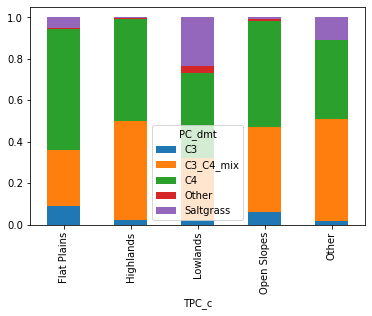

In [106]:
test.plot(kind='bar', stacked=True)

In [107]:
"""
Create dataframe of plant community coefficients by model and season
"""

pd.set_option('display.max_rows', 100)
#coefs_PC_seas = df_coefs[df_coefs['Param'].str.contains('C\(PC_dmt\, Treatment\(reference\="C3_C4_mix"\)\)\[.*\]$', regex=True)].copy(deep=True)
coefs_PC_seas = df_coefs_seas[df_coefs_seas['Param'].isin(['C4', 'C3', 'Saltgrass', 'Other'])].copy(deep=True)
#coefs_PC_seas['Param'] = coefs_PC_seas['Param'].apply(lambda x: re.sub('C\(PC_dmt, Treatment\(reference\="C3_C4_mix"\)\)\[T\.', '', x))
#coefs_PC_seas['Param'] = coefs_PC_seas['Param'].apply(lambda x: re.sub('\]', '', x))
#coefs_PC_seas = coefs_PC_seas.groupby(['Year', 'Season', 'week', 'Pasture', 'Model', 'Formula', 'Param']).mean().reset_index()
#coefs_PC_seas = coefs_PC_seas.join(df_coefs_seas.set_index(['Model', 'Year', 'Season', 'Param']).drop(columns=['coef']),
#                                                           on=['Model', 'Year', 'Season', 'Param'])
coefs_PC_seas['season'] = pd.Categorical(coefs_PC_seas['season_str'], ['early', 'mid', 'late'])
coefs_PC_seas['Param'] = pd.Categorical(coefs_PC_seas['Param'], ['C4', 'C3', 'Saltgrass', 'Other'])
coefs_PC_seas_grps = []
for grp, data in coefs_PC_seas[coefs_PC_seas['Model'].isin(['M_best'])].groupby(
    ['Year', 'season', 'Param', 'significant']).mean().reset_index().groupby(['Year', 'season']):
    coefs_PC_seas_grps.append(data.sort_values('Param'))

#coefs_PC_seas_agg = coefs_PC_seas.groupby(['Model', 'Year', 'Season', 'week', 'Pasture', 'Param']).mean().reset_index().dropna().groupby(['Model', 'Season', 'Param'])['coef'].agg(
#    [('coef_mean', np.mean),
#     ('coef_lwr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[0]),
#     ('coef_upr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[1]),
#     ('pval', lambda x: np.round(ttest_1samp(x, 0.0)[1], 4))])#.reset_index()


NameError: name 'df_coefs_seas' is not defined

In [25]:
#coefs_PC_seas_best
#df_coefs_seas[(df_coefs_seas['Model'] == 'M_best') & (df_coefs_seas['Year'] == 2016)]

In [26]:
"""
Figure: Plant community coefficients and 95% CI by sub-season and by pasture for the plant-community-only model (M3_pc) and best model (M5)
"""
coefs_PC_seas_best = coefs_PC_seas[coefs_PC_seas['Model'].isin(['M_best']) &
                                   (coefs_PC_seas['significant'] == 'Yes')].copy(deep=True)
import matplotlib.ticker as ticker
g = sns.FacetGrid(coefs_PC_seas_best, margin_titles=True, height=2.25, aspect=1.5,
                  col='season', row='Year', legend_out=True, sharey=True, gridspec_kws={"hspace":0.25, "wspace":0.1})
#plt.figure()
g.map_dataframe(sns.pointplot, x='coef', y='Param', estimator=np.mean,
                join=False, dodge=None, scale=0.75, errwidth=0.75, ci=None, color='black')

#sns.pointplot()
axs = g.axes
for idx, ax in enumerate(axs.flat):
    #ax.collections[0]
    ax.set_xlim((-1.5, 1.5))
    ax.axvline(x=0, linestyle='dotted', color='black')
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width, box.height*0.75])
    cur_title = ax.get_title()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x)))
    plt.setp(ax.texts, text="") # remove the original texts
    df_tmp = coefs_PC_seas_grps[idx].copy(deep=True)
    df_tmp['lwr'] = df_tmp['coef'] - df_tmp['coef_ci_lwr']
    df_tmp['upr'] = df_tmp['coef_ci_upr'] - df_tmp['coef'] 
    df_tmp_ns = df_tmp[df_tmp['significant'] == 'No'].copy(deep=True)
    df_tmp = df_tmp[df_tmp['significant'] == 'Yes'].copy(deep=True)
    ax.errorbar(x=df_tmp['coef'],
                y=df_tmp['Param'], 
                xerr=(df_tmp[['lwr', 'upr']].values).transpose(),
                color='black', fmt='o', zorder=0)
    ax.errorbar(x=df_tmp_ns['coef'],
            y=df_tmp_ns['Param'], 
            xerr=(df_tmp_ns[['lwr', 'upr']].values).transpose(), fmt='o', markerfacecolor='white', color='black', zorder=0)

g.set_titles(row_template = '{row_name}', col_template = '{col_name}-season', fontweight='bold')
g.set(xticks=np.arange(-1.5, 1.5, 0.5))
g.set_xlabels('Coefficient')
plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/PC_dmt.png', 
            bbox_inches='tight', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asa

In [27]:
"""
Create dataframe of topographic position class coefficients by model and season
"""
#coefs_TPC_seas = df_coefs[df_coefs['Param'].str.contains('C\(TPC_c\, Treatment\(reference\="Flat Plains"\)\)\[.*\]$', regex=True)].copy(deep=True)
coefs_TPC_seas = df_coefs_seas[df_coefs_seas['Param'].isin(['Highlands', 'Open Slopes', 'Lowlands', 'Complex'])]
#coefs_TPC_seas['Param'] = coefs_TPC_seas['Param'].apply(lambda x: re.sub('C\(TPC_c, Treatment\(reference\="Flat Plains"\)\)\[T\.', '', x))
#coefs_TPC_seas['Param'] = coefs_TPC_seas['Param'].apply(lambda x: re.sub('\]', '', x))
#coefs_TPC_seas = coefs_TPC_seas.groupby(['Year', 'Season', 'week', 'Pasture', 'Model', 'Formula', 'Param']).mean().reset_index()
#coefs_TPC_seas = coefs_TPC_seas.join(df_coefs_seas.set_index(['Model', 'Year', 'Season', 'Param']).drop(columns=['coef']),
#                                                           on=['Model', 'Year', 'Season', 'Param'])
coefs_TPC_seas['season'] = pd.Categorical(coefs_TPC_seas['season_str'], ['early', 'mid', 'late'])
coefs_TPC_seas['Param'] = pd.Categorical(coefs_TPC_seas['Param'], ['Highlands', 'Open Slopes', 'Lowlands', 'Complex'])
coefs_TPC_seas_grps = []
for grp, data in coefs_TPC_seas[coefs_TPC_seas['Model'].isin(['M_best'])].groupby(
    ['Year', 'season', 'Param', 'significant']).mean().reset_index().groupby(['Year', 'season']):
    coefs_TPC_seas_grps.append(data.sort_values('Param'))
    
#coefs_TPC_seas_agg = coefs_TPC_seas.groupby(['Model','week', 'Season', 'Year',  'Pasture', 'Param']).mean().reset_index().dropna().groupby(['Model', 'Season', 'Param'])['coef'].agg(
#    [('coef_mean', np.mean),
#     ('coef_lwr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[0]),
#     ('coef_upr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[1]),
#     ('pval', lambda x: np.round(ttest_1samp(x, 0.0)[1], 4))])#.reset_index()
#coefs_TPC_seas_agg[coefs_TPC_seas_agg.index.isin(['M1', 'M_best'], level='Model')].dropna()

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [28]:
#coefs_TPC_seas

In [29]:
"""
Figure: Plant community coefficients and 95% CI by sub-season and by pasture for the plant-community-only model (M3_pc) and best model (M5)
"""
coefs_TPC_seas_best = coefs_TPC_seas[coefs_TPC_seas['Model'].isin(['M_best']) & (coefs_TPC_seas['significant'] == 'Yes')].copy(deep=True)
import matplotlib.ticker as ticker
g = sns.FacetGrid(coefs_TPC_seas_best, margin_titles=True, height=2.25, aspect=1.5,
                  col='season', row='Year', legend_out=True, sharey=True, gridspec_kws={"hspace":0.25, "wspace":0.1})
#plt.figure()
g.map_dataframe(sns.pointplot, x='coef', y='Param', estimator=np.mean,
                join=False, dodge=None, scale=0.75, errwidth=0.75, ci=None, color='black')

#sns.pointplot()
axs = g.axes
for idx, ax in enumerate(axs.flat):
    #ax.collections[0]
    ax.set_xlim((-1.5, 1.5))
    ax.axvline(x=0, linestyle='dotted', color='black')
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width, box.height*0.75])
    cur_title = ax.get_title()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x)))
    plt.setp(ax.texts, text="") # remove the original texts
    df_tmp = coefs_TPC_seas_grps[idx].copy(deep=True)
    df_tmp['lwr'] = df_tmp['coef'] - df_tmp['coef_ci_lwr']
    df_tmp['upr'] = df_tmp['coef_ci_upr'] - df_tmp['coef'] 
    df_tmp_ns = df_tmp[df_tmp['significant'] == 'No'].copy(deep=True)
    df_tmp = df_tmp[df_tmp['significant'] == 'Yes'].copy(deep=True)
    ax.errorbar(x=df_tmp['coef'],
                y=df_tmp['Param'], 
                xerr=(df_tmp[['lwr', 'upr']].values).transpose(),
                color='black', fmt='o', zorder=0)
    ax.errorbar(x=df_tmp_ns['coef'],
            y=df_tmp_ns['Param'], 
            xerr=(df_tmp_ns[['lwr', 'upr']].values).transpose(), fmt='o', markerfacecolor='white', color='black', zorder=0)

g.set_titles(row_template = '{row_name}', col_template = '{col_name}-season', fontweight='bold')
g.set(xticks=np.arange(-1.5, 1.5, 0.5))
g.set_xlabels('Coefficient')
plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/TPC.png', 
            bbox_inches='tight', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


In [30]:
"""
Check if biomass and CP are significant in M_best models
"""
display(df_coefs_seas[(df_coefs_seas['Model'] == 'M_best') &
              (df_coefs_seas['Param'].str.contains('CP'))].sort_values(['Year', 'season']))
display(df_coefs_seas[(df_coefs_seas['Model'] == 'M_best') &
              (df_coefs_seas['Param'].str.contains('Biomass'))].sort_values(['Year', 'season']))

,Param,coef,std err,z,P>|z|,[0.025,0.975],season_str,Year,Model,coef_ci_lwr,coef_ci_upr,significant,season
21,CP,0.0535,0.045,1.196,0.232,-0.034,0.141,early,2016,M_best,-0.034,0.141,No,early
22,C3:CP,-0.1436,0.157,-0.912,0.362,-0.452,0.165,early,2016,M_best,-0.452,0.165,No,early
23,C4:CP,0.3825,0.055,6.916,0.000,0.274,0.491,early,2016,M_best,0.274,0.491,Yes,early
24,Other:CP,0.3873,0.169,2.292,0.022,0.056,0.718,early,2016,M_best,0.056,0.718,Yes,early
25,Saltgrass:CP,0.2093,0.086,2.445,0.014,0.042,0.377,early,2016,M_best,0.042,0.377,Yes,early
26,Biomass:CP,0.1096,0.024,4.641,0.000,0.063,0.156,early,2016,M_best,0.063,0.156,Yes,early
27,I(Biomass ** 2):CP,0.0317,0.013,2.464,0.014,0.006,0.057,early,2016,M_best,0.006,0.057,Yes,early
35,PC_div:CP,-0.0652,0.024,-2.685,0.007,-0.113,-0.018,early,2016,M_best,-0.113,-0.018,Yes,early
13,CP,0.2236,0.046,4.905,0.000,0.134,0.313,mid,2016,M_best,0.134,0.313,Yes,mid
14,C3:CP,-0.3413,0.094,-3.636,0.000,-0.525,-0.157,mid,2016,M_best,-0.525,-0.157,Yes,mid


,Param,coef,std err,z,P>|z|,[0.025,0.975],season_str,Year,Model,coef_ci_lwr,coef_ci_upr,significant,season
11,Biomass,-0.1782,0.024,-7.363,0.000,-0.226,-0.131,early,2016,M_best,-0.226,-0.131,Yes,early
12,C3:Biomass,-0.0861,0.070,-1.228,0.220,-0.223,0.051,early,2016,M_best,-0.223,0.051,No,early
13,C4:Biomass,0.0828,0.031,2.653,0.008,0.022,0.144,early,2016,M_best,0.022,0.144,Yes,early
14,Other:Biomass,-0.2329,0.082,-2.851,0.004,-0.393,-0.073,early,2016,M_best,-0.393,-0.073,Yes,early
15,Saltgrass:Biomass,0.2801,0.077,3.635,0.000,0.129,0.431,early,2016,M_best,0.129,0.431,Yes,early
16,I(Biomass ** 2),0.0721,0.015,4.677,0.000,0.042,0.102,early,2016,M_best,0.042,0.102,Yes,early
17,C3:I(Biomass ** 2),-0.0989,0.043,-2.324,0.020,-0.182,-0.015,early,2016,M_best,-0.182,-0.015,Yes,early
18,C4:I(Biomass ** 2),0.0478,0.022,2.210,0.027,0.005,0.090,early,2016,M_best,0.005,0.090,Yes,early
19,Other:I(Biomass ** 2),-0.0586,0.024,-2.439,0.015,-0.106,-0.012,early,2016,M_best,-0.106,-0.012,Yes,early
20,Saltgrass:I(Biomass ** 2),-0.0847,0.030,-2.850,0.004,-0.143,-0.026,early,2016,M_best,-0.143,-0.026,Yes,early


In [45]:
df_pred_bm_old = df_pred_bm.copy(deep=True)

In [111]:
"""
Biomass: how does selection change with biomass across pastures and models
"""
ref_TPC = 'Flat Plains'
ref_pc = 'C3_C4_mix'
df_pred_bm = pd.DataFrame(columns=['Year', 'season','dFence_orig', 'dTank_orig', 'Biomass_orig', 'CP_orig','PC_div_orig',
                                'PC_dmt', 'TPC_c', 'Model'])
print('Creating dataset...')
for mod in tqdm(['M_best', 'M4_top', 'M2_top']):
    for yr in yrly_mod_dict:
        for wk in yrly_mod_dict[yr]:
            for past in yrly_mod_dict[yr][wk]:
                df_sub = df_wkly_grid_train[(df_wkly_grid_train['Year'] == yr) &
                                            (df_wkly_grid_train['week'] == wk) &
                                            (df_wkly_grid_train['Pasture'] == past) &
                                            (df_wkly_grid_train['pred_rel_freq_' + mod].notnull())]
                
                for ref_pc in df_sub['PC_dmt'].unique():
                    if yrly_mod_dict[yr][wk][past][mod].params.index.str.contains('TPC_c').any():
                        for ref_TPC in df_sub['TPC_c'].unique():
                            df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC) & (df_sub['PC_dmt'] == ref_pc)]
                    else:
                        df_tmp = df_sub[df_sub['PC_dmt'] == ref_pc]
                        ref_TPC = 'All'
                    if len(df_tmp) < 10:
                        continue
                    else:
                        df_pred_bm = df_pred_bm.append(pd.DataFrame({
                            'Year': yr,
                            'week': wk,
                            'Pasture': past,
                            'season': df_tmp['season'].unique()[0],
                            'dFence_orig': df_tmp['dFence_orig'].median(),
                            'dTank_orig': df_tmp['dTank_orig'].median(),
                            'Biomass_orig': np.arange(round(df_tmp['Biomass_orig'].quantile(0.025), -1), 
                                                      round(df_tmp['Biomass_orig'].quantile(0.975), -1),  10),
                            'CP_orig': df_tmp['CP_orig'].median(),
                            'PC_div_orig': df_tmp['PC_div_orig'].median(),
                            'PC_dmt': ref_pc,
                            'TPC_c': ref_TPC,
                            'subset_wt': len(df_tmp)/len(df_sub),
                            'Model': mod
                        }))
                if len(df_sub) > 0:
                        continue
                else:
                    for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
                        scaler = scaler_dict[yr][df_sub['season'].unique()[0]][c]
                        df_pred_bm.loc[(df_pred_bm['Year'] == yr) & 
                                    (df_pred_bm['week'] == wk) &
                                    (df_pred_bm['Pasture'] == past), c] = scaler.transform(
                            df_pred_bm.loc[(df_pred_bm['Year'] == yr) & 
                                        (df_pred_bm['week'] == wk) &
                                        (df_pred_bm['Pasture'] == past), c + '_orig'].values.reshape(-1, 1)).flatten()
                    df_pred_bm.loc[(df_pred_bm['Year'] == yr) & 
                                (df_pred_bm['week'] == wk) &
                                (df_pred_bm['Pasture'] == past) &
                                (df_pred_bm['Model'] == mod), 
                                'marg_pred_bm'] = yrly_mod_dict[yr][wk][past][mod].predict(df_pred_bm.loc[(df_pred_bm['Year'] == yr) & 
                                                                                                   (df_pred_bm['week'] == wk) & 
                                                                                                   (df_pred_bm['Pasture'] == past) &
                                                                                                   (df_pred_bm['Model'] == mod)])


"""
Calculate relative frequency from predictions
"""
print('Calculating relative frequencies')

Creating dataset...


  0%|          | 0/3 [00:00<?, ?it/s]

Calculating relative frequencies


In [127]:
#df_pred_bm['season'] = pd.Categorical(df_pred_bm['season'], ['early', 'mid', 'late'])"""
df_pred_bm = df_pred_bm_old
df_pred_bm_old = df_pred_bm.copy(deep=True)
df_pred_bm = df_pred_bm[df_pred_bm['marg_pred_bm'].notnull()].groupby(['Year', 'week', 'season', 'Pasture', 'Model', 'Biomass_orig']).apply(lambda x: pd.Series({'marg_pred_bm':
                                                                                                                 np.average(x['marg_pred_bm'],
                                                                                                                            weights=x['subset_wt'])})).reset_index()

In [128]:
df_pred_bm['marg_rel_freq_bm_nm'] = df_pred_bm.groupby(['Year', 'week', 'Pasture', 'Model'])['marg_pred_bm'].transform(lambda x: x / np.nanmean(x))
df_pred_bm.loc[df_pred_bm['marg_rel_freq_bm_nm'] > 10, 'marg_rel_freq_bm_nm'] = 10

In [61]:
#df_pred_bm['marg_rel_freq_bm_nm_old'] = df_pred_bm['marg_rel_freq_bm_nm']

In [62]:
#df_pred_bm['marg_rel_freq_bm_nm'] = df_pred_bm.groupby(['Year', 'week', 'Pasture', 'Model'])['marg_pred_bm'].transform(lambda x: x / np.mean(x))
#df_pred_bm.loc[df_pred_bm['marg_rel_freq_bm_nm'] > 10, 'marg_rel_freq_bm_nm'] = 10

In [116]:
#pd.set_option('display.max_rows', None)
#df_pred_bm.groupby(['Year', 'Pasture', 'week'])['Model'].value_counts()

In [141]:
df_pred_bm[(df_pred_bm['Model'] == 'M_best') &
           (df_pred_bm['Pasture'] == '7NW') &
           (df_pred_bm['season'] == 'early')].groupby(['week'])[['marg_rel_freq_bm_nm', 'Biomass_orig']].max()

,marg_rel_freq_bm_nm,Biomass_orig
week,,
20.0,1.344834,2090.0
21.0,1.801799,2290.0
22.0,2.696062,2380.0
23.0,3.004738,2130.0
24.0,3.001315,2190.0
25.0,5.680274,2090.0


In [153]:
df_wkly_grid_train.columns

Index(['Unnamed: 0', 'Pasture', 'week', 'season_str', 'Year', 'UTM_X', 'UTM_Y',
       'Biomass', 'CP', 'dFence', 'dTank', 'PC_div', 'Biomass_orig', 'CP_orig',
       'dFence_orig', 'dTank_orig', 'PC_div_orig', 'TPC_c', 'PC_dmt',
       'grazing_secs', 'mod_data', 'grazing_wkly_sum', 'grazing_rel_freq',
       'pred_prop_M2_top', 'pred_prop_M3_top', 'pred_prop_M4_top',
       'pred_prop_M_best', 'pred_rel_freq_M2_top', 'pred_rel_freq_M3_top',
       'pred_rel_freq_M4_top', 'pred_rel_freq_M_best', 'grazing_grp',
       'pred_grp_M2_top', 'pred_grp_M3_top', 'pred_grp_M4_top',
       'pred_grp_M_best', 'season'],
      dtype='object')

In [170]:
pd.set_option('display.max_rows', 100)
#df_wkly_grid_train_long2

In [204]:
cp_bins

array([], dtype=float64)

In [50]:
bm_bins = np.arange(round(df_wkly_grid_train['Biomass_orig'].min(), -1),
                    round(df_wkly_grid_train['Biomass_orig'].max(), -1), 50)
bm_bin_labs = np.arange(len(bm_bins)-1)
bm_bin_vals = pd.cut(df_wkly_grid_train['Biomass_orig'], 
                                          bins=bm_bins, 
                                          labels=bm_bin_labs,
                                          include_lowest=True).values
df_wkly_grid_train.loc[:, 'bm_bin'] = bm_bin_vals

cp_bins = np.arange(int(df_wkly_grid_train['CP_orig'].min()),
                    np.ceil(df_wkly_grid_train['CP_orig'].max()), 0.5)
cp_bin_labs = np.arange(len(cp_bins)-1)
cp_bin_vals = pd.cut(df_wkly_grid_train['CP_orig'], 
                                          bins=cp_bins, 
                                          labels=cp_bin_labs,
                                          include_lowest=True).values
df_wkly_grid_train.loc[:, 'cp_bin'] = cp_bin_vals

/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [52]:
df_wkly_grid_train_long2 = pd.wide_to_long(df_wkly_grid_train, stubnames='pred_rel_freq', 
                i='Unnamed: 0',
                j='mod_pred_grp', sep='_', suffix='.*').reset_index()

In [53]:
df_wkly_grid_train['cp_bin_ct'] = df_wkly_grid_train.groupby(['Year', 'season', 'cp_bin'])['bm_bin'].transform(lambda x: np.sum(x.notnull()))

/tmp/ipykernel_19719/3427406746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wkly_grid_train['cp_bin_ct'] = df_wkly_grid_train.groupby(['Year', 'season', 'cp_bin'])['bm_bin'].transform(lambda x: np.sum(x.notnull()))


/tmp/ipykernel_19719/3421448586.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_dat['bm_bin'] = pd.cut(t_dat['Biomass_orig'],
/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


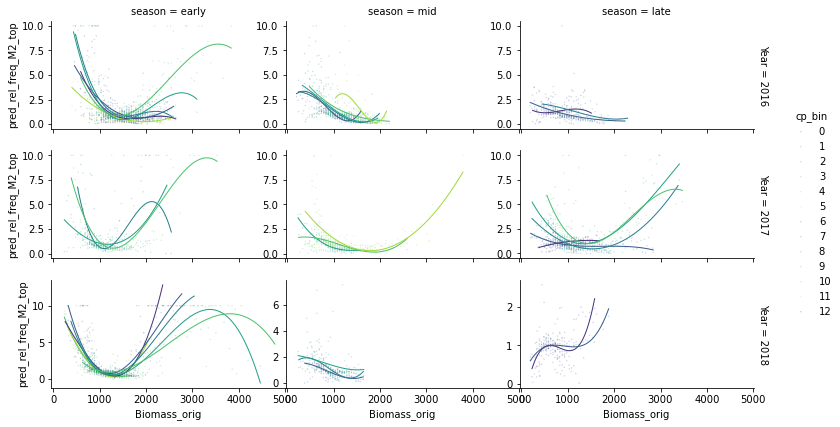

In [54]:
t_dat = df_wkly_grid_train_long2[
           (df_wkly_grid_train_long2['Pasture'] == '7NW') &
           (df_wkly_grid_train_long2['season'] == 'early') &
           (df_wkly_grid_train_long2['week'] == 25) &
           (df_wkly_grid_train_long2['Year'] == 2016)]#.sort_values('Biomass_orig').plot(x='Biomass_orig', y='pred_rel_freq_M_best')
bm_bins = np.arange(round(df_wkly_grid_train['Biomass_orig'].min(), -1),
                    round(df_wkly_grid_train['Biomass_orig'].max(), -1), 50)
bm_bin_labs = np.arange(len(bm_bins)-1)
t_dat['bm_bin'] = pd.cut(t_dat['Biomass_orig'], 
                                          bins=bm_bins, 
                                          labels=bm_bin_labs,
                                          include_lowest=True)
#g = sns.FacetGrid(data=t_dat.groupby(['mod_pred_grp', 'bm_bin']).mean().reset_index(), hue='mod_pred_grp')
#g.map_dataframe(sns.regplot, x='Biomass_orig', y='pred_rel_freq', order=2)
p_dat = df_wkly_grid_train[df_wkly_grid_train['cp_bin_ct'] > 2500].groupby(['Year', 'season', 'Pasture', 'bm_bin', 'cp_bin']).mean().reset_index()
#p_dat = p_dat
g = sns.FacetGrid(p_dat, 
                      col='season', row='Year', hue='cp_bin', 
                      col_order=['early', 'mid', 'late'],
                      #hue_order=['7NW', '15E', '17N', '20SE', '25SE', '26E', '31E'],
                      margin_titles=True,
                      legend_out=True, sharey=False, sharex=True, palette=sns.color_palette('viridis'),
                      height=2.25, aspect=1.75, gridspec_kws={"hspace":0.2, "wspace":0.0})
g.map_dataframe(sns.regplot, x='Biomass_orig', y='pred_rel_freq_M2_top',
                line_kws={'linewidth': 1}, n_boot=25, ci=None, #x_bins=10, x_ci='sd',
                order=3, scatter=True, scatter_kws={'s': 2, 
                                                    'alpha': 0.25,
                                                    'marker': 'o',
                                                    'edgecolor': 'None'}).add_legend()

In [55]:
bm_bins

array([ 160.,  210.,  260.,  310.,  360.,  410.,  460.,  510.,  560.,
        610.,  660.,  710.,  760.,  810.,  860.,  910.,  960., 1010.,
       1060., 1110., 1160., 1210., 1260., 1310., 1360., 1410., 1460.,
       1510., 1560., 1610., 1660., 1710., 1760., 1810., 1860., 1910.,
       1960., 2010., 2060., 2110., 2160., 2210., 2260., 2310., 2360.,
       2410., 2460., 2510., 2560., 2610., 2660., 2710., 2760., 2810.,
       2860., 2910., 2960., 3010., 3060., 3110., 3160., 3210., 3260.,
       3310., 3360., 3410., 3460., 3510., 3560., 3610., 3660., 3710.,
       3760., 3810., 3860., 3910., 3960., 4010., 4060., 4110., 4160.,
       4210., 4260., 4310., 4360., 4410., 4460., 4510., 4560., 4610.,
       4660., 4710., 4760., 4810., 4860.])

In [56]:
plt.figure()
df_pred_bm[(df_pred_bm['Model'] == 'M_best') &
           (df_pred_bm['Pasture'] == '7NW') &
           (df_pred_bm['season'] == 'early') &
           (df_pred_bm['week'] == 25) &
           (df_pred_bm['Year'] == 2016)].sort_values('Biomass_orig').plot(x='Biomass_orig', y='marg_rel_freq_bm_nm')

NameError: name 'df_pred_bm' is not defined

<Figure size 432x288 with 0 Axes>

In [250]:
"""
Plot marginal effects of biomass by model across weeks
"""
print('Plotting datasets and saving plots to disk')
x_var = 'Biomass_orig'

for mod in tqdm(['M_best', 'M4_top', 'M2_top']):
    g = sns.FacetGrid(df_pred_bm[df_pred_bm['Model'] == mod].groupby(['Year',
                                                                       'season',
                                                                       'Pasture',
                                                                     'Biomass_orig']).mean().reset_index(), 
                      col='season', row='Year',# hue='Pasture', 
                      col_order=['early', 'mid', 'late'],
                      #hue_order=['7NW', '15E', '17N', '20SE', '25SE', '26E', '31E'],
                      margin_titles=True,
                      legend_out=True, sharey=False, sharex=True, palette=sns.color_palette('deep'),
                      height=2.25, aspect=1.75, gridspec_kws={"hspace":0.2, "wspace":0.0})
    #plt.figure()
    g.map_dataframe(sns.regplot, x=x_var, y='marg_rel_freq_bm_nm',
                    line_kws={'linewidth': 1}, n_boot=25, ci=99, x_bins=10, x_ci='sd',
                    order=2, scatter=True, scatter_kws={'s': 2, 
                                                        'alpha': 0.25,
                                                        'marker': 'o',
                                                        'edgecolor': 'None'}).add_legend()
    g.set_xlabels('Biomass (kg/ha)')
    g.set_ylabels(None)
    axes = g.fig.axes
    for idx, ax in enumerate(axes):
        ax.axhline(y=1.0, linestyle='dashed', color='grey')
        #ax.set_ylim((0.0, ax.get_ylim()[-1]))
        ax.set_ylim((0.0, 5.0))
        ax.set_xlim((0, 2600))
        cur_title = ax.get_title()
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width*0.80, box.height])
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
        ax.xaxis.set_minor_locator(MultipleLocator(250))
        #ax.axvline(x=500, linestyle='solid', color='red')
        #ax.fill_between(range(700, 3500), 0, 1, transform=ax.get_xaxis_transform(), color='#117733', alpha=0.2, edgecolor=None, zorder=0)
        ax.fill_between(range(350, 700), 0, 1, transform=ax.get_xaxis_transform(), color='#DDCC77', alpha=0.4, edgecolor=None, zorder=0)
        ax.fill_between(range(0, 350), 0, 1, transform=ax.get_xaxis_transform(), color='#CC6677', alpha=0.4, edgecolor=None, zorder=0)
        plt.setp(ax.texts, text="") # remove the original texts
        if idx == 3:
            ax.set_ylabel('Relative probability of selection', labelpad=10)

    # Define a new Axes where the colorbar will go
    #cax = g.fig.add_axes([.90, .20, .02, .6])
    #cax.set_title('CP')
    # Get a mappable object with the same colormap as the data
    #points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap=cmap)
    # Draw the colorbar
    #g.fig.colorbar(points, cax=cax)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}-season', fontweight='bold')
    g.set(xticks=np.arange(0, 3000, 500))
    for lh in g._legend.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
    g.fig.suptitle('Marginal biomass effects: ' + mod)
    plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/Biomass_wkly_marg_' + mod  +'.png', 
                bbox_inches='tight', dpi=300)
    plt.close()
#plt.tight_layout()

Plotting datasets and saving plots to disk


  0%|          | 0/3 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


In [107]:
"""
CP: how does selection change with crude protein across pastures and models
"""
ref_TPC = 'Flat Plains'
ref_pc = 'C3_C4_mix'
df_pred_cp = pd.DataFrame(columns=['Year', 'season','dFence_orig', 'dTank_orig', 'Biomass_orig', 'CP_orig','PC_div_orig',
                                'PC_dmt', 'TPC_c', 'Model'])
print('Creating dataset...')
for mod in tqdm(mod_list):
    for yr in yrly_mod_dict:
        for wk in yrly_mod_dict[yr]:
            for past in yrly_mod_dict[yr][wk]:
                df_sub = df_wkly_grid_train[(df_wkly_grid_train['Year'] == yr) &
                                            (df_wkly_grid_train['week'] == wk) &
                                            (df_wkly_grid_train['Pasture'] == past) &
                                            (df_wkly_grid_train['pred_rel_freq_' + mod].notnull())]
                if ref_TPC is not None:
                    df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC) & (df_sub['PC_dmt'] == ref_pc)]
                else:
                    df_tmp = df_sub[(df_sub['PC_dmt'] == ref_pc)]
                if len(df_sub) < 50:
                    continue
                else:
                    df_pred_cp = df_pred_cp.append(pd.DataFrame({
                        'Year': yr,
                        'week': wk,
                        'Pasture': past,
                        'season': df_tmp['season'].unique()[0],
                        'dFence_orig': df_tmp['dFence_orig'].median(),
                        'dTank_orig': df_tmp['dTank_orig'].median(),
                        'Biomass_orig': df_tmp['Biomass_orig'].median(),
                        'CP_orig': np.arange(df_tmp['CP_orig'].quantile(0.025), df_tmp['CP_orig'].quantile(0.975), 0.1),
                        'PC_div_orig': df_tmp['PC_div_orig'].median(),
                        'PC_dmt': ref_pc,
                        'TPC_c': ref_TPC,
                        'Model': mod
                    }))
                for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
                    scaler = scaler_dict[yr][df_tmp['season'].unique()[0]][c]
                    df_pred_cp.loc[(df_pred_cp['Year'] == yr) & 
                                (df_pred_cp['week'] == wk) &
                                (df_pred_cp['Pasture'] == past), c] = scaler.transform(
                        df_pred_cp.loc[(df_pred_cp['Year'] == yr) & 
                                    (df_pred_cp['week'] == wk) &
                                    (df_pred_cp['Pasture'] == past), c + '_orig'].values.reshape(-1, 1)).flatten()
                df_pred_cp.loc[(df_pred_cp['Year'] == yr) & 
                            (df_pred_cp['week'] == wk) &
                            (df_pred_cp['Pasture'] == past) &
                            (df_pred_cp['Model'] == mod), 
                            'marg_pred_cp'] = yrly_mod_dict[yr][wk][past][mod].predict(df_pred_cp.loc[(df_pred_cp['Year'] == yr) & 
                                                                                               (df_pred_cp['week'] == wk) & 
                                                                                               (df_pred_cp['Pasture'] == past) &
                                                                                               (df_pred_cp['Model'] == mod)])
        

"""
Calculate relative frequency from predictions
"""
print('Calculating relative frequencies')
df_pred_cp['marg_rel_freq_cp'] = np.nan
for mod in tqdm(mod_list):
    for yr in df_pred_cp.Year.unique():
        for wk in df_pred_cp[df_pred_cp['Year'] == yr]['week'].unique():
            for past in df_pred_cp[(df_pred_cp['Year'] == yr) & (df_pred_cp['week'] == wk)]['Pasture'].unique():
                df_wkly_grid_sub = df_wkly_grid_train[(df_wkly_grid_train['Year'] == yr) & 
                                                     (df_wkly_grid_train['week'] == wk) & 
                                                     (df_wkly_grid_train['Pasture'] == past)]
                df_pred_cp.loc[(df_pred_cp['Year'] == yr) & 
                            (df_pred_cp['week'] == wk) &
                            (df_pred_cp['Pasture'] == past) &
                            (df_pred_cp['Model'] == mod),
                             'marg_rel_freq_cp'] = (df_pred_cp.loc[(df_pred_cp['Year'] == yr) &
                                                                (df_pred_cp['week'] == wk) &
                                                                (df_pred_cp['Pasture'] == past) &
                                                                (df_pred_cp['Model'] == mod),
                                                                'marg_pred_cp'] * df_wkly_grid_sub[
                    'grazing_wkly_sum'].mean()) / (df_wkly_grid_sub['grazing_wkly_sum'].mean() / df_wkly_grid_sub[
                    'grazing_wkly_sum'].count())

df_pred_cp['season'] = pd.Categorical(df_pred_cp['season'], ['early', 'mid', 'late'])
df_pred_cp['marg_rel_freq_cp_nm'] = df_pred_cp.groupby(['Year', 'week', 'Pasture', 'Model'])['marg_rel_freq_cp'].transform(lambda x: x / np.mean(x))

"""
Plot marginal effects of biomass and relative CP by model and season
"""
print('Plotting datasets and saving plots to disk')
x_var = 'CP_orig'

for mod in tqdm(mod_list):
    g = sns.FacetGrid(df_pred_cp[df_pred_cp['Model'] == mod], 
                      col='season', row='Year', hue='Pasture', 
                      col_order=['early', 'mid', 'late'], margin_titles=True,
                      legend_out=True, sharey=False, sharex=True, palette=sns.color_palette('deep'),
                      height=2.25, aspect=1.75, gridspec_kws={"hspace":0.2, "wspace":0.0})
    #plt.figure()
    g.map_dataframe(sns.regplot, x=x_var, y='marg_rel_freq_cp_nm',
                    line_kws={'linewidth': 1}, n_boot=25,
                    order=1, scatter=True, scatter_kws={'s': 2, 
                                                        'alpha': 0.25,
                                                        'marker': 'o',
                                                        'edgecolor': 'None'}).add_legend()
    g.set_xlabels('CP (%)')
    g.set_ylabels(None)
    axes = g.fig.axes
    for idx, ax in enumerate(axes):
        ax.axhline(y=1.0, linestyle='dashed', color='grey')
        ax.set_ylim((0.0, ax.get_ylim()[-1]))
        if ax.get_ylim()[-1] < 3.0:
            ax.set_ylim((0.0, 3.0))
        elif ax.get_ylim()[-1] < 5.0:
            ax.set_ylim((0.0, 5.0))
        elif ax.get_ylim()[-1] < 10.0:
            ax.set_ylim((0.0, 10.0))
        ax.set_xlim((5, 13))
        cur_title = ax.get_title()
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width*0.80, box.height])
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        #ax.axvline(x=500, linestyle='solid', color='red')
        #ax.fill_between(range(700, 3500), 0, 1, transform=ax.get_xaxis_transform(), color='#117733', alpha=0.2, edgecolor=None, zorder=0)
        ax.fill_between(range(7, 9), 0, 1, transform=ax.get_xaxis_transform(), color='#DDCC77', alpha=0.4, edgecolor=None, zorder=0)
        ax.fill_between(range(5, 8), 0, 1, transform=ax.get_xaxis_transform(), color='#CC6677', alpha=0.4, edgecolor=None, zorder=0)
        plt.setp(ax.texts, text="") # remove the original texts
        if idx == 3:
            ax.set_ylabel('Relative probability of selection', labelpad=10)

    # Define a new Axes where the colorbar will go
    #cax = g.fig.add_axes([.90, .20, .02, .6])
    #cax.set_title('CP')
    # Get a mappable object with the same colormap as the data
    #points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap=cmap)
    # Draw the colorbar
    #g.fig.colorbar(points, cax=cax)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}-season', fontweight='bold')
    g.set(xticks=np.arange(5, 13, 1))
    for lh in g._legend.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
    g.fig.suptitle('Marginal CP effects: ' + mod)
    plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/CP_wkly_marg_' + mod  +'.png', 
                bbox_inches='tight', dpi=300)
    plt.close()
#plt.tight_layout()

In [110]:
"""
Diversity: how does selection change with crude protein across pastures and models
"""
ref_TPC = 'Flat Plains'
ref_pc = 'C3_C4_mix'
df_pred_div = pd.DataFrame(columns=['Year', 'season','dFence_orig', 'dTank_orig', 'Biomass_orig', 'CP_orig','PC_div_orig',
                                'PC_dmt', 'TPC_c', 'Model'])
print('Creating dataset...')
for mod in tqdm(mod_list):
    for yr in yrly_mod_dict:
        for wk in yrly_mod_dict[yr]:
            for past in yrly_mod_dict[yr][wk]:
                df_sub = df_wkly_grid_train[(df_wkly_grid_train['Year'] == yr) &
                                            (df_wkly_grid_train['week'] == wk) &
                                            (df_wkly_grid_train['Pasture'] == past) &
                                            (df_wkly_grid_train['pred_rel_freq_' + mod].notnull())]
                if ref_TPC is not None:
                    df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC) & (df_sub['PC_dmt'] == ref_pc)]
                else:
                    df_tmp = df_sub[(df_sub['PC_dmt'] == ref_pc)]
                if len(df_sub) < 50:
                    continue
                else:
                    df_pred_div = df_pred_div.append(pd.DataFrame({
                        'Year': yr,
                        'week': wk,
                        'Pasture': past,
                        'season': df_tmp['season'].unique()[0],
                        'dFence_orig': df_tmp['dFence_orig'].median(),
                        'dTank_orig': df_tmp['dTank_orig'].median(),
                        'Biomass_orig': df_tmp['Biomass_orig'].median(),
                        'CP_orig': df_tmp['CP_orig'].median(),
                        'PC_div_orig': np.arange(df_tmp['PC_div_orig'].quantile(0.025), df_tmp['PC_div_orig'].quantile(0.975), 0.1),
                        'PC_dmt': ref_pc,
                        'TPC_c': ref_TPC,
                        'Model': mod
                    }))
                for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
                    scaler = scaler_dict[yr][df_tmp['season'].unique()[0]][c]
                    df_pred_div.loc[(df_pred_div['Year'] == yr) & 
                                (df_pred_div['week'] == wk) &
                                (df_pred_div['Pasture'] == past), c] = scaler.transform(
                        df_pred_div.loc[(df_pred_div['Year'] == yr) & 
                                    (df_pred_div['week'] == wk) &
                                    (df_pred_div['Pasture'] == past), c + '_orig'].values.reshape(-1, 1)).flatten()
                df_pred_div.loc[(df_pred_div['Year'] == yr) & 
                            (df_pred_div['week'] == wk) &
                            (df_pred_div['Pasture'] == past) &
                            (df_pred_div['Model'] == mod), 
                            'marg_pred_div'] = yrly_mod_dict[yr][wk][past][mod].predict(df_pred_div.loc[(df_pred_div['Year'] == yr) & 
                                                                                               (df_pred_div['week'] == wk) & 
                                                                                               (df_pred_div['Pasture'] == past) &
                                                                                               (df_pred_div['Model'] == mod)])
        

"""
Calculate relative frequency from predictions
"""
print('Calculating relative frequencies')
df_pred_div['marg_rel_freq_div'] = np.nan
for mod in tqdm(mod_list):
    for yr in df_pred_div.Year.unique():
        for wk in df_pred_div[df_pred_div['Year'] == yr]['week'].unique():
            for past in df_pred_div[(df_pred_div['Year'] == yr) & (df_pred_div['week'] == wk)]['Pasture'].unique():
                df_wkly_grid_sub = df_wkly_grid_train[(df_wkly_grid_train['Year'] == yr) & 
                                                     (df_wkly_grid_train['week'] == wk) & 
                                                     (df_wkly_grid_train['Pasture'] == past)]
                df_pred_div.loc[(df_pred_div['Year'] == yr) & 
                            (df_pred_div['week'] == wk) &
                            (df_pred_div['Pasture'] == past) &
                            (df_pred_div['Model'] == mod),
                             'marg_rel_freq_div'] = (df_pred_div.loc[(df_pred_div['Year'] == yr) &
                                                                (df_pred_div['week'] == wk) &
                                                                (df_pred_div['Pasture'] == past) &
                                                                (df_pred_div['Model'] == mod),
                                                                'marg_pred_div'] * df_wkly_grid_sub[
                    'grazing_wkly_sum'].mean()) / (df_wkly_grid_sub['grazing_wkly_sum'].mean() / df_wkly_grid_sub[
                    'grazing_wkly_sum'].count())

df_pred_div['season'] = pd.Categorical(df_pred_div['season'], ['early', 'mid', 'late'])
df_pred_div['marg_rel_freq_div_nm'] = df_pred_div.groupby(['Year', 'week', 'Pasture', 'Model'])['marg_rel_freq_div'].transform(lambda x: x / np.mean(x))

"""
Plot marginal effects
"""
print('Plotting datasets and saving plots to disk')
x_var = 'PC_div_orig'

for mod in tqdm(mod_list):
    g = sns.FacetGrid(df_pred_div[df_pred_div['Model'] == mod], 
                      col='season', row='Year', hue='Pasture', 
                      col_order=['early', 'mid', 'late'], margin_titles=True,
                      legend_out=True, sharey=False, sharex=True, palette=sns.color_palette('deep'),
                      height=2.25, aspect=1.75, gridspec_kws={"hspace":0.2, "wspace":0.0})
    #plt.figure()
    g.map_dataframe(sns.regplot, x=x_var, y='marg_rel_freq_div_nm',
                    line_kws={'linewidth': 1}, n_boot=25,
                    order=1, scatter=True, scatter_kws={'s': 2, 
                                                        'alpha': 0.25,
                                                        'marker': 'o',
                                                        'edgecolor': 'None'}).add_legend()
    g.set_xlabels('Plant community diversity (Shannon-H)')
    g.set_ylabels(None)
    axes = g.fig.axes
    for idx, ax in enumerate(axes):
        ax.axhline(y=1.0, linestyle='dashed', color='grey')
        ax.set_ylim((0.0, ax.get_ylim()[-1]))
        if ax.get_ylim()[-1] < 3.0:
            ax.set_ylim((0.0, 3.0))
        elif ax.get_ylim()[-1] < 5.0:
            ax.set_ylim((0.0, 5.0))
        elif ax.get_ylim()[-1] < 10.0:
            ax.set_ylim((0.0, 10.0))
        ax.set_xlim((0, 2.0))
        cur_title = ax.get_title()
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width*0.80, box.height])
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        plt.setp(ax.texts, text="") # remove the original texts
        if idx == 3:
            ax.set_ylabel('Relative probability of selection', labelpad=10)

    # Define a new Axes where the colorbar will go
    #cax = g.fig.add_axes([.90, .20, .02, .6])
    #cax.set_title('CP')
    # Get a mappable object with the same colormap as the data
    #points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap=cmap)
    # Draw the colorbar
    #g.fig.colorbar(points, cax=cax)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}-season', fontweight='bold')
    g.set(xticks=np.arange(0, 2.5, 0.5))
    for lh in g._legend.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
    g.fig.suptitle('Marginal Diversity effects: ' + mod)
    plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/DIV_wkly_marg_' + mod  +'.png', 
                bbox_inches='tight', dpi=300)
    plt.close()
#plt.tight_layout()

Creating dataset...


  0%|          | 0/4 [00:00<?, ?it/s]

Calculating relative frequencies


  0%|          | 0/4 [00:00<?, ?it/s]

Plotting datasets and saving plots to disk


  0%|          | 0/4 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


In [229]:
"""
Plant Community: how does selection change with plant community class across pastures and models
"""
ref_TPC = 'Flat Plains'
df_pred_pc = pd.DataFrame(columns=['Year', 'season','dFence_orig', 'dTank_orig', 'Biomanp.average', 'CP_orig','PC_div_orig',
                                'PC_dmt', 'TPC_c', 'Model', 'TPC_wt'])
print('Creating dataset...')
idx=0
for mod in tqdm(mod_list):
    for yr in yrly_mod_dict:
        for wk in yrly_mod_dict[yr]:
            for past in yrly_mod_dict[yr][wk]:
                df_sub = df_wkly_grid_train[(df_wkly_grid_train['Year'] == yr) &
                                            (df_wkly_grid_train['week'] == wk) &
                                            (df_wkly_grid_train['Pasture'] == past) &
                                            (df_wkly_grid_train['pred_rel_freq_' + mod].notnull())]
                for ref_pc in df_sub['PC_dmt'].unique():
                    if yrly_mod_dict[yr][wk][past][mod].params.index.str.contains('TPC_c').any():
                        for ref_TPC in df_sub['TPC_c'].unique():
                            df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC) & (df_sub['PC_dmt'] == ref_pc)]
                            if len(df_tmp) < 10:
                                continue
                            else:
                                df_pred_pc = df_pred_pc.append(pd.DataFrame({
                                    'Year': yr,
                                    'week': wk,
                                    'Pasture': past,
                                    'season': df_tmp['season'].unique()[0],
                                    'dFence_orig': df_tmp['dFence_orig'].median(),
                                    'dTank_orig': df_tmp['dTank_orig'].median(),
                                    'Biomass_orig': df_tmp['Biomass_orig'].median(),
                                    'CP_orig': df_tmp['CP_orig'].median(),
                                    'PC_div_orig': df_tmp['PC_div_orig'].median(),
                                    'PC_dmt': ref_pc,
                                    'TPC_c': ref_TPC,
                                    'Model': mod,
                                    'TPC_wt': len(df_tmp)/len(df_sub[df_sub['PC_dmt'] == ref_pc])
                                }, index=[idx]))
                                idx+=1
                    else:
                        df_tmp = df_sub[(df_sub['PC_dmt'] == ref_pc)]
                    if len(df_tmp) < 10:
                        continue
                    else:
                        df_pred_pc = df_pred_pc.append(pd.DataFrame({
                            'Year': yr,
                            'week': wk,
                            'Pasture': past,
                            'season': df_tmp['season'].unique()[0],
                            'dFence_orig': df_tmp['dFence_orig'].median(),
                            'dTank_orig': df_tmp['dTank_orig'].median(),
                            'Biomass_orig': df_tmp['Biomass_orig'].median(),
                            'CP_orig': df_tmp['CP_orig'].median(),
                            'PC_div_orig': df_tmp['PC_div_orig'].median(),
                            'PC_dmt': ref_pc,
                            'TPC_c': ref_TPC,
                            'Model': mod,
                            'TPC_wt': len(df_tmp)/len(df_sub[df_sub['PC_dmt'] == ref_pc])
                        }, index=[idx]))
                        idx+=1
                    for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
                        scaler = scaler_dict[yr][df_tmp['season'].unique()[0]][c]
                        df_pred_pc.loc[(df_pred_pc['Year'] == yr) & 
                                    (df_pred_pc['week'] == wk) &
                                    (df_pred_pc['Pasture'] == past), c] = scaler.transform(
                            df_pred_pc.loc[(df_pred_pc['Year'] == yr) & 
                                        (df_pred_pc['week'] == wk) &
                                        (df_pred_pc['Pasture'] == past), c + '_orig'].values.reshape(-1, 1)).flatten()
                    df_pred_pc.loc[(df_pred_pc['Year'] == yr) & 
                                (df_pred_pc['week'] == wk) &
                                (df_pred_pc['Pasture'] == past) &
                                (df_pred_pc['Model'] == mod), 
                                'marg_pred_pc'] = yrly_mod_dict[yr][wk][past][mod].predict(df_pred_pc.loc[(df_pred_pc['Year'] == yr) & 
                                                                                                   (df_pred_pc['week'] == wk) & 
                                                                                                   (df_pred_pc['Pasture'] == past) &
                                                                                                   (df_pred_pc['Model'] == mod)])
df_pred_pc = df_pred_pc.groupby(['Year',
                                 'season',
                                 'week', 
                                 'Pasture', 
                                 'Model', 
                                 'PC_dmt']).apply(lambda x: pd.Series({'marg_pred_pc':
                                                                       np.average(x['marg_pred_pc'], weights=x['TPC_wt'])})).reset_index()

Creating dataset...


  0%|          | 0/4 [00:00<?, ?it/s]

In [230]:
"""
Calculate relative frequency from predictions
"""
print('Calculating relative frequencies')
df_pred_pc['marg_rel_freq_pc'] = np.nan
for mod in tqdm(mod_list):
    for yr in df_pred_pc.Year.unique():
        for wk in df_pred_pc[df_pred_pc['Year'] == yr]['week'].unique():
            for past in df_pred_pc[(df_pred_pc['Year'] == yr) & (df_pred_pc['week'] == wk)]['Pasture'].unique():
                df_wkly_grid_sub = df_wkly_grid_train[(df_wkly_grid_train['Year'] == yr) & 
                                                     (df_wkly_grid_train['week'] == wk) & 
                                                     (df_wkly_grid_train['Pasture'] == past)]
                df_pred_pc.loc[(df_pred_pc['Year'] == yr) & 
                            (df_pred_pc['week'] == wk) &
                            (df_pred_pc['Pasture'] == past) &
                            (df_pred_pc['Model'] == mod),
                             'marg_rel_freq_pc'] = (df_pred_pc.loc[(df_pred_pc['Year'] == yr) &
                                                                (df_pred_pc['week'] == wk) &
                                                                (df_pred_pc['Pasture'] == past) &
                                                                (df_pred_pc['Model'] == mod),
                                                                'marg_pred_pc'] * df_wkly_grid_sub[
                    'grazing_wkly_sum'].mean()) / (df_wkly_grid_sub['grazing_wkly_sum'].mean() / df_wkly_grid_sub[
                    'grazing_wkly_sum'].count())

df_pred_pc['marg_rel_freq_pc_nm'] = df_pred_pc.groupby(['Year', 'week', 'Pasture', 'Model'])['marg_rel_freq_pc'].transform(lambda x: x / np.mean(x))
df_pred_pc['season'] = pd.Categorical(df_pred_pc['season'], ['early', 'mid', 'late'])
df_pred_pc['PC_dmt'] = pd.Categorical(df_pred_pc['PC_dmt'], ['C4', 'C3_C4_mix', 'C3', 'Saltgrass', 'Other'])

Calculating relative frequencies


  0%|          | 0/4 [00:00<?, ?it/s]

In [231]:
df_pred_pc[(df_pred_pc['Pasture'] == '25SE') & (df_pred_pc['Model'] == 'M_best')].groupby(['Year', 'season'])['PC_dmt'].value_counts()

Year    season           
2016.0  early   C4           4
                C3_C4_mix    4
                C3           0
                Saltgrass    0
                Other        0
        mid     C4           6
                C3_C4_mix    6
                Other        2
                C3           0
                Saltgrass    0
        late    C4           6
                C3_C4_mix    6
                Other        4
                C3           0
                Saltgrass    0
2017.0  early   C4           6
                C3_C4_mix    6
                Other        2
                C3           0
                Saltgrass    0
        mid     C4           4
                C3_C4_mix    4
                C3           0
                Saltgrass    0
                Other        0
        late    C4           4
                C3_C4_mix    4
                Other        1
                C3           0
                Saltgrass    0
2018.0  early   C4           6
             

In [232]:
"""
Plot marginal effects
"""
print('Plotting datasets and saving plots to disk')
y_var = 'PC_dmt'

for mod in tqdm(['M_best', 'M3_top', 'M4_top']):
    #g = sns.FacetGrid(df_pred_pc[df_pred_pc['Model'] == mod], 
    #                  col='season', row='Year', hue='Pasture', 
    #                  col_order=['early', 'mid', 'late'], margin_titles=True,
    #                  legend_out=True, sharey=True, sharex=True, palette=sns.color_palette('deep'),
    #                  height=2.25, aspect=1.75, gridspec_kws={"hspace":0.2, "wspace":0.0})
    #plt.figure()
    g = sns.factorplot(x='marg_rel_freq_pc_nm', y=y_var, data=df_pred_pc[df_pred_pc['Model'] == mod],
                    join=False, orient='h', dodge=0.4,
                      col='season', row='Year', hue='Pasture', 
                      col_order=['early', 'mid', 'late'], margin_titles=True,
                      legend_out=True, sharey=True, sharex=True, palette=sns.color_palette('deep'),
                      height=2.25, aspect=1.75, gridspec_kws={"hspace":0.2, "wspace":0.0})
    #g.map_dataframe(sns.pointplot, x='marg_rel_freq_pc_nm', y=y_var,
    #                join=False, orient='h').add_legend()
    g.set_xlabels('Relative probability of selection')
    g.set_ylabels(None)
    axes = g.fig.axes
    for idx, ax in enumerate(axes):
        ax.axvline(x=1.0, linestyle='dashed', color='grey')
        #ax.set_ylim((-1.0, 5.0))
        #if ax.get_xlim()[-1] < 3.0:
        #    ax.set_xlim((0.0, 3.0))
        #elif ax.get_xlim()[-1] < 5.0:
        #    ax.set_xlim((0.0, 5.0))
        #elif ax.get_xlim()[-1] < 10.0:
        #    ax.set_xlim((0.0, 10.0))
        cur_title = ax.get_title()
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width*0.80, box.height*0.85])
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        plt.setp(ax.texts, text="") # remove the original texts
        if idx == 3:
            ax.set_ylabel('Plant community', labelpad=10)
        else:
            ax.set_ylabel('')

    # Define a new Axes where the colorbar will go
    #cax = g.fig.add_axes([.90, .20, .02, .6])
    #cax.set_title('CP')
    # Get a mappable object with the same colormap as the data
    #points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap=cmap)
    # Draw the colorbar
    #g.fig.colorbar(points, cax=cax)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}-season', fontweight='bold')
    g.set(yticks=[0, 1, 2, 3, 4, 5])
    #for lh in g._legend.legendHandles: 
    #    lh.set_alpha(1)
    #    lh._sizes = [10]
    g.fig.suptitle('Marginal Plant Community effects: ' + mod)
    plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/PC_wkly_marg_' + mod  +'.png', 
                bbox_inches='tight', dpi=300)
    plt.close()
#plt.tight_layout()

Plotting datasets and saving plots to disk


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [111]:
plt.close('all')

In [33]:
"""
Compare top model by plant community diversity: how does selection change with plant community diversity within dominant plant communities?
"""
ref_TPC = 'Flat Plains'
df_pred = pd.DataFrame(columns=['Year', 'season', 'dFence_orig', 'dTank_orig', 'Biomass_orig', 'CP_orig','PC_div_orig',
                                'PC_dmt', 'TPC_c'])
for (yr, seas), df_sub in df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'train'].groupby(['Year', 'season']):
    print(yr, seas)
    if ref_TPC is not None:
        df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC)]
    else:
        df_tmp = df_sub
    if not (coefs_dict[yr][seas]['M_best']['Param'] == 'PC_div').any():
        continue
    if np.sign(coefs_dict[yr][seas]['M_best'].set_index('Param').loc['PC_div']['[0.025']) != \
    np.sign(coefs_dict[yr][seas]['M_best'].set_index('Param').loc['PC_div']['0.975]']):
        continue
    if (coefs_dict[yr][seas]['M_best']['Param'] == 'C3').any():
        if (coefs_dict[yr][seas]['M_best']['Param'] == 'C3:PC_div').any():
            for ref_pc in df_wkly_grid_full['PC_dmt'][df_wkly_grid_full['mod_data'] == 'train'].unique():
                df_tmp2 = df_tmp[df_tmp['PC_dmt'] == ref_pc]
                if len(df_tmp2) < 50:
                    continue
                if ref_pc != 'C3_C4_mix':
                    if np.sign(coefs_dict[yr][seas]['M_best'].set_index('Param').loc[ref_pc + ':PC_div']['[0.025']) != \
                    np.sign(coefs_dict[yr][seas]['M_best'].set_index('Param').loc[ref_pc + ':PC_div']['0.975]']):
                        continue
                df_pred = df_pred.append(pd.DataFrame({
                    'Year': yr,
                    'season': seas,
                    'dFence_orig': df_tmp2['dFence_orig'].median(),
                    'dTank_orig': df_tmp2['dTank_orig'].median(),
                    'Biomass_orig': df_tmp2['Biomass_orig'].median(),
                    'CP_orig': df_tmp2['CP_orig'].median(),
                    'PC_div_orig': np.linspace(df_tmp2['PC_div_orig'].quantile(0.005),
                                               df_tmp2['PC_div_orig'].quantile(0.995), 25),
                    'PC_dmt': ref_pc,
                    'TPC_c': ref_TPC,
                    'step': np.arange(25)
                }))
            
        else:
            ref_pc = 'C3_C4_mix'
            df_tmp = df_tmp[(df_tmp['PC_dmt'] == ref_pc)]
            if len(df_tmp) < 50:
                continue
            df_pred = df_pred.append(pd.DataFrame({
                'Year': yr,
                'season': seas,
                'dFence_orig': df_tmp['dFence_orig'].median(),
                'dTank_orig': df_tmp['dTank_orig'].median(),
                'Biomass_orig': df_tmp['Biomass_orig'].median(),
                'CP_orig': df_tmp['CP_orig'].median(),
                'PC_div_orig': np.linspace(df_tmp['PC_div_orig'].quantile(0.005),
                                           df_tmp['PC_div_orig'].quantile(0.995), 25),
                'PC_dmt': ref_pc,
                'TPC_c': ref_TPC,
                'step': np.arange(25)
            }))
    else:
        if len(df_tmp) < 50:
            continue
        df_pred = df_pred.append(pd.DataFrame({
            'Year': yr,
            'season': seas,
            'dFence_orig': df_tmp['dFence_orig'].median(),
            'dTank_orig': df_tmp['dTank_orig'].median(),
            'Biomass_orig': df_tmp['Biomass_orig'].median(),
            'CP_orig': df_tmp['CP_orig'].median(),
            'PC_div_orig': np.linspace(df_tmp['PC_div_orig'].quantile(0.005), 
                                       df_tmp['PC_div_orig'].quantile(0.995), 25),
            'PC_dmt': 'Overall',
            'TPC_c': ref_TPC,
            'step': np.arange(25)
        }))
    for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
        scaler = scaler_dict[yr][seas][c]
        df_pred.loc[(df_pred['Year'] == yr) & 
                    (df_pred['season'] == seas), c] = scaler.transform(
            df_pred.loc[(df_pred['Year'] == yr) & 
                        (df_pred['season'] == seas), c + '_orig'].values.reshape(-1, 1)).flatten()
    df_pred.loc[(df_pred['Year'] == yr) & 
                (df_pred['season'] == seas), 
                'mod_pred'] = yrly_mod_dict[yr][seas]['M_best'].predict(df_pred.loc[(df_pred['Year'] == yr) &
                                                                               (df_pred['season'] == seas)])
    
df_pred['season'] = pd.Categorical(df_pred['season'], ['early', 'mid', 'late'])
df_pred['pred_rel_freq'] = np.nan
for yr in df_pred.Year.unique():
    for seas in df_pred.season.unique():
        df_wkly_grid_sub = df_wkly_grid_full[(df_wkly_grid_full['Year'] == yr) & 
                                             (df_wkly_grid_full['season'] == seas) & 
                                             (df_wkly_grid_full['mod_data'] == 'train')]
        df_pred.loc[(df_pred['Year'] == yr) & 
                    (df_pred['season'] == seas), 'pred_rel_freq'] = (df_pred.loc[(df_pred['Year'] == yr) &
                                                                                 (df_pred['season'] == seas), 'mod_pred'] * df_wkly_grid_sub['grazing_wkly_sum'].mean()) / (df_wkly_grid_sub.groupby('Pasture')['grazing_wkly_sum'].mean().mean() / df_wkly_grid_sub.groupby(
            ['Pasture'])['grazing_wkly_sum'].count().mean())
        
        #if not (mbest_coefs_dict[yr][seas]['Param'] == 'PC_dmt:C3').any():
        #    df_pred_tmp = df_pred[(df_pred['Year'] == yr) &
        #                          (df_pred['season'] == seas)].groupby(['step']).mean()
        #    df_pred_tmp['PC_dmt'] = 'Average'
        #    df_pred_tmp['season'] = seas
        #    df_pred_tmp['Year'] = yr
        #    df_pred = df_pred[~((df_pred['Year'] == yr) &
        #                        (df_pred['season'] == seas))]
        #    df_pred = df_pred.append(df_pred_tmp)

2016 early
2016 mid
2016 late
2017 early
2017 mid
2017 late
2018 early
2018 mid
2018 late


In [34]:
"""
Plot marginal effects of plant community diversity by dominant plant community and season
"""
x_var = 'PC_div_orig'
hue_order = [x for x in ['C4', 'C3_C4_mix', 'C3', 'Saltgrass', 'Other', 'Overall'] if x in df_pred['PC_dmt'].unique()]
hue_labels = ['C3/C4 mix' if x == 'C3_C4_mix' else x for x in hue_order]
g = sns.FacetGrid(df_pred, col='season', row='Year', hue='PC_dmt',
                  col_order=['early', 'mid', 'late'], 
                  hue_order=hue_order, palette=['blue', 'olive', 'darkorange', 'pink', 'grey', 'black'],
                  margin_titles=True,
                  legend_out=True, sharey=False, height=2.25, aspect=1.5, gridspec_kws={"hspace":0.2, "wspace":0.2})
#plt.figure()
g.map_dataframe(sns.lineplot, x=x_var, y='pred_rel_freq').add_legend(bbox_to_anchor=(1.075, 0.5))
g.set_xlabels(None)
g.set_ylabels(None)
axes = g.axes.flat
for idx, ax in enumerate(axes):
    ax.axhline(y=1.0, linestyle='dashed', color='grey')
    ax.set_ylim((0.0, ax.get_ylim()[-1]))
    #if ax.get_ylim()[-1] < 3.0:
    ax.set_ylim((0.0, 3.0))
    cur_title = ax.get_title()
    plt.setp(ax.texts, text="") # remove the original texts
    if idx == 3:
        ax.set_ylabel('Relative probability of selection', labelpad=10)
    if idx == 7:
        ax.set_xlabel('Plant community diversity (Shannon H)', labelpad=10)
if len(hue_order) > 1:
    for ax in axes:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width*0.6, box.height*0.9])
    leg = g.legend
    # change legend texts
    new_title = 'Plant community'
    leg.set_title(new_title, prop={'weight': 'bold',
            'size': 12,
            })
    new_labels=hue_labels
    for t, l in zip(leg.texts, new_labels):
        t.set_text(l)
else:
    g.legend.remove()
g.set(xticks=np.arange(0, 2.5, 0.5))
g.set_titles(row_template = '{row_name}', col_template = '{col_name}-season', fontweight='bold')
plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/PC_div_X_PC_dmt.png',
            bbox_inches='tight', dpi=300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


In [ ]:
df_wkly_grid_full[(df_wkly_grid_full.Year == 2016)&
            (df_wkly_grid_full.season == 'mid') &
                  (df_wkly_grid_full.TPC_c == 'Flat Plains') &
                 (df_wkly_grid_full.PC_dmt == 'Other') &
                 (df_wkly_grid_full.mod_data == 'test')]['PC_div_orig'].describe()

In [ ]:
df_wkly_grid_full.columns

In [ ]:
df_wkly_grid_train['Pasture'].unique()

In [ ]:
import xarray as xr
xr_dat_past = df_wkly_grid_train[df_wkly_grid_train['Pasture'] == '7NW'].set_index(['Year', 'week', 'UTM_Y', 'UTM_X']).to_xarray()

In [58]:
#df_wkly_grid_train_means[df_wkly_grid_train_means['Pasture'] == '7NW']['pred_seas_grp_val']#.value_counts()

In [59]:
pc_dmt_dict = {
    'C4': 1.0,
    'C3_C4_mix': 2.0,
    'C3': 3.0,
    'Saltgrass': 4.0,
    'Other': 5.0
}

tpc_dict = {
    'Highlands': 1.0,
    'Open Slopes': 2.0,
    'Flat Plains': 3.0,
    'Lowlands': 4.0,
    'Other': 5.0
}

pred_grps_dict = {
    'Low': 1,
    'Mod. Low': 2,
    'Avg.': 3,
    'Mod. Hi': 4,
    'Hi': 5
}


def convert_from_dict(x, set_dict):
    return set_dict[x] if x in set_dict else x
    
xr_dat_past['PC_dmt_val'] = xr.apply_ufunc(convert_from_dict, xr_dat_past['PC_dmt'],
                                           kwargs={'set_dict': pc_dmt_dict}, vectorize=True, dask='parallelized')
xr_dat_past['TPC_val'] = xr.apply_ufunc(convert_from_dict, xr_dat_past['TPC_c'],
                                           kwargs={'set_dict': tpc_dict}, vectorize=True, dask='parallelized')
xr_dat_past['pred_seas_grp_val'] = xr.apply_ufunc(convert_from_dict, xr_dat_past['pred_seas_grp'],
                                                   kwargs={'set_dict': pred_grps_dict}, vectorize=True, dask='parallelized')
#xr_dat_past['PC_div'] = xr_dat_past['PC_div'].fillna(0)

ValueError: cannot convert float NaN to integer

In [36]:
#xr_dat_early['grazing_rel_freq'].quantile(0.98)

In [37]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors, cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

tpc_labels = ['Complex' if x == 'Other' else x for x in tpc_dict.keys()]

tpc_cmap = colors.ListedColormap(['orange', 'yellow', 'lightgreen', 'darkgreen', 'red'])
tpc_patches =[mpatches.Patch(color=c, label=list(tpc_labels)[i]) for i, c in enumerate(tpc_cmap.colors)]

pc_dmt_cmap = colors.ListedColormap(['blue', 'olive', 'darkorange', 'pink', 'grey'])
pc_patches =[mpatches.Patch(color=c, label=list(pc_dmt_dict.keys())[i]) for i, c in enumerate(pc_dmt_cmap.colors)]

rel_use_breaks = [0, 0.001, 0.5, 0.75, 0.9, 1.0, 1.25, 2.0, 3.0, 4.0, 1000]
rel_use_labels = ['None', 'V. low', 'Low', 'Mod. low', 'Avg.', 'Mod. hi', 'Hi', 'V. Hi', 'Ext. Hi']
rel_use_cmap = cm.get_cmap('Spectral_r', len(rel_use_breaks))
res_use_patches =[mpatches.Patch(color=rel_use_cmap(i), 
                                   label=rel_use_labels[i]) for i in np.arange(len(rel_use_labels))]
# Create the colormap
cmap_rel_use = colors.LinearSegmentedColormap.from_list(
            'Relative use', [rel_use_cmap(i) for i in np.arange(len(rel_use_labels))],
    N=len(rel_use_labels))
norm = colors.BoundaryNorm(rel_use_breaks, len(rel_use_breaks))


yr = 2016
xr_dat_early = xr_dat_past.sel(Year=yr, week=21)
xr_dat_mid = xr_dat_past.sel(Year=yr, week=27)
xr_dat_late = xr_dat_past.sel(Year=yr, week=33)

cax_fsize=8
cax_title_fsize=10
cax_pad=0.10

fig = plt.figure(figsize=(14, 10))

gs1 = GridSpec(1, 3, top=0.98, bottom=0.65, wspace=0.05)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])
ax1.imshow(xr_dat_early['TPC_val'].sortby('UTM_Y', ascending=False).data, cmap=tpc_cmap)
ax1.legend(handles=tpc_patches, ncol=3, bbox_to_anchor=(0.5, 1.4), fontsize=8, 
           loc='upper center', frameon=False,
           title="$\\bf{Topographic\ Position\ Class}$", title_fontsize=10)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('top', size='10%', pad=cax_pad)
cax1.axes.set_visible(False)

ax2.imshow(xr_dat_early['PC_dmt_val'].sortby('UTM_Y', ascending=False).data, cmap=pc_dmt_cmap)
ax2.legend(handles=pc_patches, ncol=3, bbox_to_anchor=(0.5, 1.4), fontsize=8, 
           loc='upper center', frameon=False,
           title="$\\bf{Dominant\ Plant\ Community (PC)}$", title_fontsize=10)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('top', size='10%', pad=cax_pad)
cax2.axes.set_visible(False)

im3 = ax3.imshow(xr_dat_early['PC_div_orig'].sortby('UTM_Y', ascending=False).data, cmap='cividis', vmin=0.0, vmax=1.5)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('top', size='10%', pad=cax_pad)
cbar3 = fig.colorbar(im3, cax=cax3, orientation='horizontal')
cax3.xaxis.set_ticks_position('top')
cax3.set_title("$\\bf{PC\ Diversity\ (Shannon\ H)}$", fontsize=10)
cbar3.ax.tick_params(labelsize=8)

gs2 = GridSpec(3, 4, top=0.65, bottom=0.02, hspace=0.01)
ax4 = fig.add_subplot(gs2[0, 0])
ax5 = fig.add_subplot(gs2[0, 1])
ax6 = fig.add_subplot(gs2[0, 2])
ax7 = fig.add_subplot(gs2[0, 3])
im4 = ax4.imshow(xr_dat_early['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('top', size='10%', pad=cax_pad)
cbar4 = fig.colorbar(im4, cax=cax4, orientation='horizontal')
cax4.xaxis.set_ticks_position('top')
cax4.set_title("$\\bf{Biomass\ (kg/ha)}$", fontsize=10)
cbar4.ax.tick_params(labelsize=8)
#cax4left = divider4.append_axes('left', size='5%', pad=0.05)
#cax4left.yaxis.set_label("early-season")

im5 = ax5.imshow(xr_dat_early['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes('top', size='10%', pad=cax_pad)
cbar5 = fig.colorbar(im5, cax=cax5, orientation='horizontal')
cax5.xaxis.set_ticks_position('top')
cax5.set_title("$\\bf{Crude\ Protein\ (\%)}$", fontsize=10)
cbar5.ax.tick_params(labelsize=8)

im6 = ax6.imshow(xr_dat_early['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap='Spectral_r', vmin=0, vmax=4)
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes('top', size='10%', pad=cax_pad)
cbar6 = fig.colorbar(im6, cax=cax6, orientation='horizontal')
cax6.xaxis.set_ticks_position('top')
cax6.set_title("$\\bf{Relative\ use}$", fontsize=10)
cbar6.ax.tick_params(labelsize=8)

ax7.imshow(xr_dat_early['pred_seas_grp_val'].sortby('UTM_Y', ascending=False).data, cmap=pred_grps_cmap)
divider7 = make_axes_locatable(ax7)
cax7 = divider7.append_axes('top', size='10%', pad=cax_pad)
cax7.axes.set_visible(False)
ax7.legend(handles=pred_grps_patches, ncol=3, bbox_to_anchor=(0.5, 1.55), fontsize=8, 
           loc='upper center', frameon=False, title="$\\bf{Predicted\ use}$", title_fontsize=10)

ax8 = fig.add_subplot(gs2[1, 0])
ax9 = fig.add_subplot(gs2[1, 1])
ax10 = fig.add_subplot(gs2[1, 2])
ax11 = fig.add_subplot(gs2[1, 3])
ax8.imshow(xr_dat_mid['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
ax9.imshow(xr_dat_mid['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
ax10.imshow(xr_dat_mid['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap='Spectral_r', vmin=0.0, vmax=4)
ax11.imshow(xr_dat_mid['pred_seas_grp_val'].sortby('UTM_Y', ascending=False).data, cmap=pred_grps_cmap)

ax12 = fig.add_subplot(gs2[2, 0])
ax13 = fig.add_subplot(gs2[2, 1])
ax14 = fig.add_subplot(gs2[2, 2])
ax15 = fig.add_subplot(gs2[2, 3])
ax12.imshow(xr_dat_late['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
ax13.imshow(xr_dat_late['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
ax14.imshow(xr_dat_late['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap='Spectral_r', vmin=0.0, vmax=4)
ax15.imshow(xr_dat_late['pred_seas_grp_val'].sortby('UTM_Y', ascending=False).data, cmap=pred_grps_cmap)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]:
    #ax.axis('off')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
ax4.set_ylabel("$\\bf{early{-}season}$" + "\n(week 21)", fontdict={'size': 12}, labelpad=15)
ax8.set_ylabel("$\\bf{mid{-}season}$" + "\n(week 27)", fontdict={'size': 12}, labelpad=15)
ax12.set_ylabel("$\\bf{late{-}season}$" + "\n(week 33)", fontdict={'size': 12}, labelpad=15)


plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/Pasture_example_' + str(yr) + '.png',
            bbox_inches='tight', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'pred_grps_cmap' is not defined

In [60]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors, cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

tpc_labels = ['Complex' if x == 'Other' else x for x in tpc_dict.keys()]

tpc_cmap = colors.ListedColormap(['orange', 'yellow', 'lightgreen', 'darkgreen', 'red'])
tpc_patches =[mpatches.Patch(color=c, label=list(tpc_labels)[i]) for i, c in enumerate(tpc_cmap.colors)]

pc_dmt_cmap = colors.ListedColormap(['blue', 'olive', 'darkorange', 'pink', 'grey'])
pc_patches =[mpatches.Patch(color=c, label=list(pc_dmt_dict.keys())[i]) for i, c in enumerate(pc_dmt_cmap.colors)]

rel_use_breaks = [0, 0.001, 0.5, 0.75, 0.9, 1.0, 1.25, 2.5, 4.0, 1000]
rel_use_labels = ['None', '', 'Low', '', 'Avg.', '', 'Hi', '', 'V. Hi', '']
rel_use_cmap = cm.get_cmap('Spectral_r', len(rel_use_breaks))
res_use_patches =[mpatches.Patch(color=rel_use_cmap(i), 
                                   label=rel_use_labels[i]) for i in np.arange(len(rel_use_labels))]
# Create the colormap
cmap_rel_use = colors.LinearSegmentedColormap.from_list(
            'Relative use', [rel_use_cmap(i) for i in np.arange(len(rel_use_labels))],
    N=len(rel_use_labels))
norm_rel_use = colors.BoundaryNorm(rel_use_breaks, len(rel_use_breaks))

yr = 2017
xr_dat_early = xr_dat_past.sel(Year=yr, week=21)
xr_dat_mid = xr_dat_past.sel(Year=yr, week=27)
xr_dat_late = xr_dat_past.sel(Year=yr, week=33)

cax_fsize=8
cax_title_fsize=10
cax_pad=0.10

fig = plt.figure(figsize=(14, 10))

gs1 = GridSpec(1, 3, top=0.98, bottom=0.65, wspace=0.05)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])
ax1.imshow(xr_dat_early['TPC_val'].sortby('UTM_Y', ascending=False).data, cmap=tpc_cmap)
ax1.legend(handles=tpc_patches, ncol=3, bbox_to_anchor=(0.5, 1.4), fontsize=8, 
           loc='upper center', frameon=False,
           title="$\\bf{Topographic\ Position\ Class}$", title_fontsize=10)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('top', size='10%', pad=cax_pad)
cax1.axes.set_visible(False)

ax2.imshow(xr_dat_early['PC_dmt_val'].sortby('UTM_Y', ascending=False).data, cmap=pc_dmt_cmap)
ax2.legend(handles=pc_patches, ncol=3, bbox_to_anchor=(0.5, 1.4), fontsize=8, 
           loc='upper center', frameon=False,
           title="$\\bf{Dominant\ Plant\ Community (PC)}$", title_fontsize=10)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('top', size='10%', pad=cax_pad)
cax2.axes.set_visible(False)

im3 = ax3.imshow(xr_dat_early['PC_div_orig'].sortby('UTM_Y', ascending=False).data, cmap='cividis', vmin=0.0, vmax=1.5)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('top', size='10%', pad=cax_pad)
cbar3 = fig.colorbar(im3, cax=cax3, orientation='horizontal')
cax3.xaxis.set_ticks_position('top')
cax3.set_title("$\\bf{PC\ Diversity\ (Shannon\ H)}$", fontsize=10)
cbar3.ax.tick_params(labelsize=8)

gs2 = GridSpec(3, 3, top=0.65, bottom=0.02, hspace=0.01)
ax4 = fig.add_subplot(gs2[0, 0])
ax5 = fig.add_subplot(gs2[0, 1])
ax6 = fig.add_subplot(gs2[0, 2])
im4 = ax4.imshow(xr_dat_early['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('top', size='10%', pad=cax_pad)
cbar4 = fig.colorbar(im4, cax=cax4, orientation='horizontal')
cax4.xaxis.set_ticks_position('top')
cax4.set_title("$\\bf{Biomass\ (kg/ha)}$", fontsize=10)
cbar4.ax.tick_params(labelsize=8)
#cax4left = divider4.append_axes('left', size='5%', pad=0.05)
#cax4left.yaxis.set_label("early-season")

im5 = ax5.imshow(xr_dat_early['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes('top', size='10%', pad=cax_pad)
cbar5 = fig.colorbar(im5, cax=cax5, orientation='horizontal')
cax5.xaxis.set_ticks_position('top')
cax5.set_title("$\\bf{Crude\ Protein\ (\%)}$", fontsize=10)
cbar5.ax.tick_params(labelsize=8)

im6 = ax6.imshow(xr_dat_early['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap=cmap_rel_use, norm=norm_rel_use)
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes('top', size='10%', pad=cax_pad)
cbar6 = fig.colorbar(im6, cax=cax6, orientation='horizontal')
cax6.xaxis.set_ticks_position('top')
cax6.set_title("$\\bf{Relative\ use}$", fontsize=10)
cbar6.ax.tick_params(labelsize=8)
cbar6.ax.set_xticklabels(rel_use_labels)

ax8 = fig.add_subplot(gs2[1, 0])
ax9 = fig.add_subplot(gs2[1, 1])
ax10 = fig.add_subplot(gs2[1, 2])
ax8.imshow(xr_dat_mid['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
ax9.imshow(xr_dat_mid['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
ax10.imshow(xr_dat_mid['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap=cmap_rel_use, norm=norm_rel_use)

ax12 = fig.add_subplot(gs2[2, 0])
ax13 = fig.add_subplot(gs2[2, 1])
ax14 = fig.add_subplot(gs2[2, 2])
ax12.imshow(xr_dat_late['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
ax13.imshow(xr_dat_late['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
ax14.imshow(xr_dat_late['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap=cmap_rel_use, norm=norm_rel_use)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax8, ax9, ax10, ax12, ax13, ax14]:
    #ax.axis('off')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
ax1.set_ylabel("$\\bf{static}$", fontdict={'size': 12}, labelpad=15)
ax4.set_ylabel("$\\bf{early{-}season}$" + "\n(week 21)", fontdict={'size': 12}, labelpad=15)
ax8.set_ylabel("$\\bf{mid{-}season}$" + "\n(week 27)", fontdict={'size': 12}, labelpad=15)
ax12.set_ylabel("$\\bf{late{-}season}$" + "\n(week 33)", fontdict={'size': 12}, labelpad=15)


plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/Pasture_example_' + str(yr) + '_no_pred.png',
            bbox_inches='tight', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [211]:
xr_dat_early['Biomass_orig'].isel(dict(UTM_X=10, UTM_Y=15))['UTM_X']

<xarray.DataArray 'UTM_X' ()>
array(525945.)
Coordinates:
    Year     int64 2018
    week     int64 21
    UTM_Y    float64 4.521e+06
    UTM_X    float64 5.259e+05

In [210]:
'te' in 'test'

True

In [156]:
"""
Compare models by season: how does selection change with distance to fence and watertank
"""
ref_TPC = 'Flat Plains'
ref_pc = 'C3_C4_mix'
df_pred = pd.DataFrame(columns=['season','dFence_orig', 'dTank_orig', 'Biomass_orig', 'CP_orig','PC_div_orig',
                                'PC_dmt', 'TPC_c', 'Feature', 'Model'])
for mod in tqdm(['M1', 'M_best']):
    for seas, df_sub in df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'train'].groupby('season'):
        if len(df_sub[(df_sub['PC_dmt'] == ref_pc) & (df_sub['TPC_c'] == ref_TPC)]) < 100:
            continue
        else:
            df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC) & (df_sub['PC_dmt'] == ref_pc)]
            for feat in ['Fence', 'Tank']:
                if feat == 'Fence':
                    dFence = np.arange(df_tmp['dFence_orig'].min(), df_tmp['dFence_orig'].max(), 10)
                else:
                    dFence = df_tmp['dFence_orig'].median()
                if feat == 'Tank':
                    dTank = np.arange(df_tmp['dTank_orig'].min(), df_tmp['dTank_orig'].max(), 10)
                else:
                    dTank = df_tmp['dTank_orig'].median()
                    
                df_pred = df_pred.append(pd.DataFrame({
                    'season': seas,
                    'dFence_orig': dFence,
                    'dTank_orig': dTank,
                    'Biomass_orig': df_tmp['Biomass_orig'].median(),
                    'CP_orig': df_tmp['CP_orig'].median(),
                    'PC_div_orig': df_tmp['PC_div_orig'].median(),
                    'PC_dmt': ref_pc,
                    'TPC_c': ref_TPC,
                    'Feature': feat,
                    'Model': mod
                }))
        for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
            scaler = scaler_dict[seas][c]
            df_pred.loc[df_pred['season'] == seas, c] = scaler.transform(
                df_pred.loc[df_pred['season'] == seas, c + '_orig'].values.reshape(-1, 1)).flatten()
        df_pred.loc[(df_pred['season'] == seas) & (df_pred['Model'] == mod), 
                    'mod_pred'] = seas_mod_dict[seas][mod].predict(df_pred.loc[(df_pred['season'] == seas) & (df_pred['Model'] == mod)])
df_pred['season'] = pd.Categorical(df_pred['season'], ['early', 'mid', 'late'])
df_pred['pred_rel_freq'] = np.nan
for seas in df_pred.season.unique():
    df_wkly_grid_sub = df_wkly_grid_full[(df_wkly_grid_full['season'] == seas) & (df_wkly_grid_full['mod_data'] == 'train')]
    df_pred.loc[df_pred['season'] == seas, 'pred_rel_freq'] = (df_pred.loc[df_pred['season'] == seas, 'mod_pred'] * df_wkly_grid_sub['grazing_wkly_sum'].mean()) / (df_wkly_grid_sub['grazing_wkly_sum'].mean() / df_wkly_grid_sub.groupby(
        ['week', 'Pasture', 'Steer_ID'])['grazing_wkly_sum'].count().mean())

  0%|          | 0/2 [00:00<?, ?it/s]

KeyError: 'early'

In [26]:
df_pred['dFence_orig'][df_pred['Feature'] == 'Tank'] = np.nan
df_pred['dTank_orig'][df_pred['Feature'] == 'Fence'] = np.nan
df_pred_long = pd.melt(df_pred, id_vars=['season', 'Model', 'Feature', 'pred_rel_freq'], value_vars=['dFence_orig', 'dTank_orig'], value_name='Distance')

C:\Users\SEAN~1.KEA\AppData\Local\Temp/ipykernel_6360/1498154917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['dFence_orig'][df_pred['Feature'] == 'Tank'] = np.nan
C:\Users\SEAN~1.KEA\AppData\Local\Temp/ipykernel_6360/1498154917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['dTank_orig'][df_pred['Feature'] == 'Fence'] = np.nan


In [28]:
"""
Plot marginal effects of distance to fence by model and season
"""
x_var = 'Distance'
g = sns.FacetGrid(df_pred_long[(df_pred_long['Model'].isin(['M1', 'M_best'])) & (df_pred_long['Feature'] == 'Fence')],
                  col='season', hue='Model',
                               col_order=['early', 'mid', 'late'], 
                  legend_out=True, sharey='col', sharex=True)
#plt.figure()
g.map_dataframe(sns.lineplot, x=x_var, y='pred_rel_freq').add_legend(bbox_to_anchor=(0.5, 0.98), 
                                                                     loc='upper center',
                                                                                                   borderaxespad=0, 
                                                                                                   ncol=2, 
                                                                                                   frameon=True)
g.set_xlabels('Distance to nearest fence (m)')
g.set_ylabels('Relative probability of selection')
axes = g.fig.axes
for ax in axes:
    ax.axhline(y=1.0, linestyle='dashed', color='grey')
    ax.set_ylim((0.0, ax.get_ylim()[-1]))
    if ax.get_ylim()[-1] < 2.0:
        ax.set_ylim((0.0, 2.0))
    cur_title = ax.get_title()
    ax.set_title(re.sub('season = ', '', cur_title + '-season'))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height*0.8])
leg = g.legend
# change legend texts
new_title = 'Model type'
leg.set_title(new_title, prop={'weight': 'bold',
        'size': 12,
        })
new_labels = ['Null model (M0)', 'Fully paramaterized (M5)']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/dfence.png', 
            bbox_inches='tight', dpi=300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
"""
Plot marginal effects of distance to water tank by model and season
"""
x_var = 'Distance'
g = sns.FacetGrid(df_pred_long[(df_pred_long['Model'].isin(['M1', 'M_best'])) & (df_pred_long['Feature'] == 'Tank')],
                  col='season', hue='Model',
                               col_order=['early', 'mid', 'late'], 
                  legend_out=True, sharey='col', sharex=True)
#plt.figure()
g.map_dataframe(sns.lineplot, x=x_var, y='pred_rel_freq').add_legend(bbox_to_anchor=(0.5, 0.98), 
                                                                     loc='upper center',
                                                                                                   borderaxespad=0, 
                                                                                                   ncol=2, 
                                                                                                   frameon=True)
g.set_xlabels('Distance to water tank (m)')
g.set_ylabels('Relative probability of selection')
axes = g.fig.axes
for ax in axes:
    ax.axhline(y=1.0, linestyle='dashed', color='grey')
    ax.set_ylim((0.0, ax.get_ylim()[-1]))
    if ax.get_ylim()[-1] < 2.0:
        ax.set_ylim((0.0, 2.0))
    cur_title = ax.get_title()
    ax.set_title(re.sub('season = ', '', cur_title + '-season'))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height*0.8])
leg = g.legend
# change legend texts
new_title = 'Model type'
leg.set_title(new_title, prop={'weight': 'bold',
        'size': 12,
        })
new_labels = ['Null model (M0)', 'Fully paramaterized (M5)']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/dtank.png', 
            bbox_inches='tight', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [32]:
plt.figure()
sns.kdeplot(x='grazing_rel_freq', hue='season', 
            data=df_wkly_grid_train, bw_adjust=2.0, clip=(0, None),
           common_norm=False, cumulative=False, common_grid=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='grazing_rel_freq', ylabel='Density'>

In [49]:
df_wkly_grid_train['grazing_rel_freq_seas'] = (df_wkly_grid_train.groupby(['season', 'Pasture', 'Steer_ID', 'UTM_X', 'UTM_Y']).grazing_secs.transform('sum') /\
(df_wkly_grid_train.groupby(['season', 'Pasture', 'Steer_ID', 'UTM_X', 'UTM_Y']).grazing_wkly_sum.transform('sum') /\
 df_wkly_grid_train.groupby(['week', 'season', 'Pasture', 'Steer_ID']).grazing_secs.transform(lambda x: np.mean(len(x))))).reset_index(drop=True)

In [50]:
#df_wkly_grid_train[df_wkly_grid_train['mod_data'] == 'train']

In [51]:
#df_wkly_grid_train[(df_wkly_grid_train.Pasture == '7NW') &
#                 (df_wkly_grid_train.UTM_X == 524055.0) & 
#                 (df_wkly_grid_train.UTM_Y == 4522695.0) &
                  #(df_wkly_grid_train.Steer_ID == '2287_D1_2017') & 
#                 (df_wkly_grid_train.mod_data == 'train')].sort_values('Steer_ID')

In [52]:
df_wkly_grid_train['grazing_rel_freq_seas_grp'] = pd.cut(df_wkly_grid_train.groupby(['season', 'Pasture', 'UTM_X', 'UTM_Y'])['grazing_rel_freq_seas'].transform('mean'), 
                                          bins=rel_freq_bins, 
                                          labels=bin_labs,
                                          include_lowest=True)
df_wkly_grid_train['grazing_rel_freq_past_grp'] = pd.cut(df_wkly_grid_train.groupby(['week', 'Pasture', 'UTM_X', 'UTM_Y'])['grazing_rel_freq'].transform('mean'), 
                                          bins=rel_freq_bins, 
                                          labels=bin_labs,
                                          include_lowest=True)

In [59]:
df_wkly_grid_train.groupby('season')['grazing_secs'].apply(lambda x: np.sum(np.isnan(x)))

season
early    1
mid      0
late     0
Name: grazing_secs, dtype: int64

In [40]:
df_seas_grid = df_wkly_grid_train.groupby(['season', 'mod_data', 'Pasture',
                           'UTM_X', 'UTM_Y'])[['grazing_rel_freq_seas', 
                                                           'grazing_rel_freq_seas_grp',
                                                           'Biomass_orig',
                                                           'CP_orig', 
                                                           'PC_dmt', 
                                                           'PC_div_orig']].aggregate(func={
    'grazing_rel_freq_seas': 'last',
    'grazing_rel_freq_seas_grp': 'last',
    'Biomass_orig': np.mean,
    'CP_orig': np.mean,
    'PC_dmt': 'last',
    'PC_div_orig': 'last'
}).reset_index()
    #['mod_data', 'Pasture', 'Steer_ID', 'UTM_X', 'UTM_Y'])['grazing_rel_freq_wkly_grp'].transform(lambda x: '_'.join(x.astype('str')))

In [45]:
df_seas_grid['grazing_rel_freq_seas_grp'].dropna()

691397      Low
691398      Low
691399      Low
691400     Avg.
691401      Low
           ... 
4128583    Avg.
4128584      Hi
4128585      Hi
4128586      Hi
4128904      Hi
Name: grazing_rel_freq_seas_grp, Length: 25953, dtype: category
Categories (5, object): ['Low' < 'Mod. Low' < 'Avg.' < 'Mod. Hi' < 'Hi']

In [41]:
df_seas_grid = df_seas_grid[df_seas_grid['mod_data'] == 'train']
df_seas_grid['grazing_rel_freq_seas_traj'] = df_seas_grid.groupby(['mod_data', 'Pasture', 
                      'UTM_X', 'UTM_Y'])['grazing_rel_freq_seas_grp'].transform('_'.join)
df_seas_grid['season'] = pd.Categorical(df_seas_grid['season'], ['early', 'mid', 'late'])

TypeError: sequence item 0: expected str instance, float found

In [86]:
plt.figure()
sns.pointplot(x='season', y='Biomass', hue='grazing_rel_freq_seas_traj', 
            data=df_seas_grid[df_seas_grid['grazing_rel_freq_seas_traj'].isin(['Low_Low_Low',
                                                                               'Hi_Hi_Hi'])])

C:\Users\SEAN~1.KEA\AppData\Local\Temp/ipykernel_96040/2580292971.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='season', ylabel='Biomass'>

In [89]:
plt.figure()
sns.pointplot(x='season', y='PC_div', hue='grazing_rel_freq_seas_traj', 
            data=df_seas_grid[df_seas_grid['grazing_rel_freq_seas_traj'].isin(['Low_Low_Low',
                                                                               'Hi_Hi_Hi'])])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='season', ylabel='PC_div'>

In [53]:
df_seas_grid['grazing_rel_freq_seas_traj'][df_seas_grid['season'] == 'late'].value_counts()

Low_Low_Low                 733
Hi_Hi_Hi                    296
Mod. Low_Low_Low            276
Low_Mod. Low_Low            245
Low_Low_Mod. Low            171
                           ... 
Mod. Hi_Mod. Hi_Mod. Hi      15
Mod. Hi_Mod. Hi_Mod. Low     13
Mod. Low_Mod. Hi_Mod. Hi     12
Mod. Hi_Mod. Low_Mod. Hi     11
Low_Mod. Hi_Mod. Hi           8
Name: grazing_rel_freq_seas_traj, Length: 125, dtype: int64

In [65]:
#plt.figure()
df_plot = df_wkly_grid_train[df_wkly_grid_train['mod_data'] == 'train'].groupby(
    ['season', 'week', 'Pasture', 'Steer_ID'])['grazing_rel_freq_seas_grp'].value_counts().reset_index().groupby(
    ['season', 'Pasture', 'level_4']).mean().reset_index().pivot(columns='level_4',
                                                               index=['season', 'Pasture'], values='grazing_rel_freq_seas_grp').reset_index()#.plot(kind='bar', stacked=True)
df_plot['pct_Hi'] = df_plot[['Hi']].sum(axis=1) / df_plot[['Low', 'Mod. Low', 'Avg.', 
                                                  'Mod. Hi', 'Hi']].sum(axis=1)
df_plot['season'] = pd.Categorical(df_plot['season'], ['early', 'mid', 'late'])
#df_plot
plt.figure()
sns.pointplot(x='season', y='pct_Hi', hue='Pasture', data=df_plot)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='season', ylabel='pct_Hi'>

In [66]:
df_wkly_grid_train[df_wkly_grid_train['mod_data'] == 'train'].pivot(index=['Pasture', 'UTM_X', 'UTM_Y'])

level_4,season,Pasture,Low,Mod. Low,Avg.,Mod. Hi,Hi,pct_Hi
0,early,15E,524.833333,253.000000,208.666667,122.166667,318.833333,0.223351
1,early,17N,393.833333,342.000000,261.000000,97.666667,288.333333,0.208509
2,early,20SE,422.000000,294.000000,315.333333,119.666667,269.000000,0.189437
3,early,26E,415.333333,313.000000,272.000000,125.333333,249.333333,0.181333
4,early,31E,402.666667,355.333333,360.666667,179.333333,323.666667,0.199589
5,early,7NW,392.833333,318.000000,270.500000,140.833333,264.500000,0.190745
6,late,15E,354.250000,246.250000,368.500000,166.750000,295.000000,0.206186
7,late,17N,486.750000,249.750000,266.000000,97.250000,283.000000,0.204665
8,late,20SE,424.750000,291.250000,287.250000,141.250000,276.250000,0.194440
9,late,26E,450.500000,251.500000,264.000000,116.500000,295.000000,0.214156


In [ ]:
#plt.figure()
df_plot = df_wkly_grid_train[df_wkly_grid_train['mod_data'] == 'train'].groupby(
    ['season', 'week', 'Pasture', 'Steer_ID'])['grazing_rel_freq_seas_grp'].value_counts().reset_index().groupby(
    ['season', 'Pasture', 'level_4']).mean().reset_index().pivot(columns='level_4',
                                                               index=['season', 'Pasture'], values='grazing_rel_freq_seas_grp').reset_index()#.plot(kind='bar', stacked=True)
df_plot['pct_Hi'] = df_plot[['Hi']].sum(axis=1) / df_plot[['Low', 'Mod. Low', 'Avg.', 
                                                  'Mod. Hi', 'Hi']].sum(axis=1)
df_plot['season'] = pd.Categorical(df_plot['season'], ['early', 'mid', 'late'])
#df_plot
plt.figure()
sns.pointplot(x='season', y='pct_Hi', hue='Pasture', data=df_plot)

In [46]:
"""
Save data to make Sankey diagrams in R
"""
df_sankey = pd.DataFrame(columns=['class_early', 'class_mid', 'class_late', 'value'])
df_sankey['class_early'] = df_seas_grid[df_seas_grid['season'] == 'early']['grazing_rel_freq_seas_grp'].reset_index(drop=True)
df_sankey['class_mid'] = df_seas_grid[df_seas_grid['season'] == 'mid']['grazing_rel_freq_seas_grp'].reset_index(drop=True)
df_sankey['class_late'] = df_seas_grid[df_seas_grid['season'] == 'late']['grazing_rel_freq_seas_grp'].reset_index(drop=True)
df_sankey['value'] = 1
sankey_grp = df_sankey.groupby(['class_early', 'class_mid', 'class_late']).sum().reset_index(drop=False)
sankey_grp = sankey_grp.reindex(columns=sankey_grp.columns.tolist())
sankey_grp.to_csv('C:/SPK_local/zTEMP/gps_grid_sankey2.csv')

In [11]:
aicw_func = lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min())))
aicd_func = lambda x: x - x.min()

In [38]:
"""
Analyze best results for specific model comparisons defined in dictionary above
"""
for k in mod_aic_dict:
    df_results.loc[df_results['model'].isin(mod_aic_dict[k]), 
                   'AICw_' + k] = df_results.loc[df_results['model'].isin(mod_aic_dict[k])].groupby(
        ['week', 'Pasture'])['AIC'].transform(aicw_func)
    df_results.loc[df_results['model'].isin(mod_aic_dict[k]), 
                   'AICd_' + k] = df_results.loc[df_results['model'].isin(mod_aic_dict[k])].groupby(
        ['week', 'Pasture'])['AIC'].transform(aicd_func)
    df_results['top_model_' + k] = df_results.groupby(['week', 'Pasture'])['AICw_' + k].transform(
        lambda x: [int(i) for i in x == x.max()])
    df_results['candidate_model_' + k] = df_results.groupby(['week', 'Pasture'])['AICd_' + k].transform(
        lambda x: [int(i) for i in x <= 2.0])

In [39]:
"""
Display the results for the desired model comparison
"""
mod_grp = 'Hw2'
display(df_results.loc[df_results['model'].isin(mod_aic_dict[mod_grp])].groupby(['season', 'model'])[['top_model_' + mod_grp, 'candidate_model_' + mod_grp,
                                                                                'AICw_' + mod_grp, 'AICd_' + mod_grp]].aggregate(
    func={'AICd_' + mod_grp: [np.median, np.std], 'AICw_' + mod_grp: [np.mean, np.std], 
         'top_model_' + mod_grp: np.sum, 'candidate_model_' + mod_grp: np.sum}, axis=1).sort_values(['season', ('AICd_' + mod_grp, 'median')]))
display(df_results.loc[df_results['model'].isin(mod_aic_dict[mod_grp])].groupby(['model'])[['top_model_' + mod_grp, 'candidate_model_' + mod_grp, 
                                                                      'AICw_' + mod_grp, 'AICd_' + mod_grp]].aggregate(
    func={'AICd_' + mod_grp: [np.median, np.std], 'AICw_' + mod_grp: [np.mean, np.std], 
          'top_model_' + mod_grp: np.sum, 'candidate_model_' + mod_grp: np.sum}, axis=1).sort_values(('AICd_' + mod_grp, 'median')))

AICd_Hw2                  AICw_Hw2           top_model_Hw2  \
               median         std          mean       std           sum   
season model                                                              
early  M2g      0.275    1.081198  5.061748e-01  0.296941             9   
       M2f      3.650   15.116630  2.215112e-01  0.240397             4   
       M2e      6.540   15.016862  1.527321e-01  0.249046             3   
       M2d     19.350   53.099368  3.105445e-02  0.063824             0   
       M2b     28.545   41.595856  4.482712e-02  0.091801             1   
       M2a     46.480   59.347148  2.105054e-02  0.066307             0   
       M2c     55.240   83.766058  2.264990e-02  0.095805             1   
late   M2g      0.000    1.393833  5.669245e-01  0.357838             7   
       M2f      3.970   13.607834  1.704526e-01  0.196187             2   
       M2e     17.635   17.977953  1.075712e-01  0.192545             1   
       M2d     22.035   29.178889  6.553204e-02  0.153503             1   
       M2b     28.425   32.462956  8.392830e-02  0.201161             1   
       M2c     34.785  163.188775  6.374583e-04  0.001683             0   
       M2a     48.850   38.307737  4.953916e-03  0.011591             0   
mid    M2g      0.000    1.147310  6.540285e-01  0.360957            12   
       M2f     10.395   34.692182  1.217726e-01  0.168370             2   
       M2e     16.580   29.966809  1.357531e-01  0.215604             2   
       M2d     35.230   36.685161  5.904228e-02  0.134963             1   
       M2b     90.820  106.598850  2.932907e-02  0.123558             1   
       M2a    105.395  110.054974  7.381332e-05  0.000313             0   
       M2c    160.450  114.654101  5.493250e-07  0.000002             0   

             candidate_model_Hw2  
                             sum  
season model                      
early  M2g                    16  
       M2f                     8  
       M2e                     5  
       M2d                     3  
       M2b                     2  
       M2a                     1  
       M2c                     1  
late   M2g                    10  
       M2f                     5  
       M2e                     3  
       M2d                     2  
       M2b                     2  
       M2c                     0  
       M2a                     0  
mid    M2g                    16  
       M2f                     6  
       M2e                     5  
       M2d                     2  
       M2b                     1  
       M2a                     0  
       M2c                     0

AICd_Hw2              AICw_Hw2           top_model_Hw2  \
        median         std      mean       std           sum   
model                                                          
M2g      0.000    1.166435  0.576807  0.336463            28   
M2f      4.550   25.114508  0.171345  0.205110             8   
M2e     13.790   22.678330  0.135075  0.219630             6   
M2d     20.395   41.549821  0.050169  0.117503             2   
M2b     38.480   83.472705  0.048791  0.136041             3   
M2a     71.340   89.428555  0.009160  0.041377             0   
M2c     87.710  120.894697  0.008653  0.058657             1   

      candidate_model_Hw2  
                      sum  
model                      
M2g                    42  
M2f                    19  
M2e                    13  
M2d                     7  
M2b                     5  
M2a                     1  
M2c                     1